In [5]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr#;xr.set_options(display_style='text') 
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

import sys
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)

from tools.wrfHrTools import *
from tools.generalTools import qsat,compute_N
from orographicPrecipitation.observationsAndERA5.linearWaveModels import second_derivative_matrix,linear_w_generalized, linear_w_generalized_forced, w_to_Tprime,w_to_qprime,z_to_p_standard
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile,k_vector

SCRATCH='/global/cscratch1/sd/qnicolas/'

import scipy.linalg as spl
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

from calc_GW_LRF import coupled_gw_mode_damped, gw_mode_forced_damped

%load_ext autoreload
%autoreload 2

In [6]:
DZ = 100.
zz_full = np.arange(0.,20e3,DZ)
N0=0.01;U0=10;k0=2*np.pi/100e3;hhat0=1.

In [1]:
import numpy as np

In [4]:
np.sqrt(-1+0.1j)

(0.04993777183700243+1.0012461141278126j)

# Functions

In [7]:
kuangdata = loadmat("/global/u2/q/qnicolas/orographicPrecipitation/steadyLRF.mat")

Mkuang=kuangdata['M']
pres=kuangdata['pres'][:,0]
tmean=kuangdata['tmean'][:,0]
qmean=kuangdata['qmean'][:,0]
zrce = kuangdata['z'][:,0]
zT = zrce[:-2]
zQ = zrce[:14]

#Reverse positive eigenvalue
lambdas,P = spl.eig(Mkuang)
lambdas[5]*=-1
Pm1 = spl.inv(P)
Mkuang2 = np.real(np.dot(np.dot(P,np.diag(lambdas)),Pm1))

In [8]:
def QcQqfromTq(MM,zM,zforc,forcT,forcq):
    forcT_interp = np.interp(zM,zforc,forcT)[:26]
    forcq_interp = np.interp(zM,zforc,forcq)[:14]
    forcing=np.concatenate((forcT_interp,forcq_interp))
    reps = np.dot(MM,forcing)
    repQc = np.concatenate((reps[:26],[0.,0.]))
    repQq = np.concatenate((reps[26:],np.zeros(14)))
    return np.interp(zforc,zM,repQc,left=0.,right=0.),np.interp(zforc,zM,repQq,left=0.,right=0.)

In [9]:
from calc_GW_LRF import *

In [10]:
g = 9.81
Lv = 2.5e6
cp=1004.
Rd = 287.
T0=300.

In [11]:
class SimulationCustom(Simulation):
    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False):
        super().__init__(path,center,dx,inp,out,pout,is_subset)
        self.suffix2 = suffix2
        self.RAINNC  = xr.open_zarr(self.path+'wrf.SFCVARS.1h.%s.zarr'%self.suffix2).RAINNC_MMDY
        self.T_PL_MEAN = xr.open_dataarray(self.path+'wrf.T_PL.ALLMEAN.nc')
        self.Q_PL_MEAN = xr.open_dataarray(self.path+'wrf.Q_PL.ALLMEAN.nc')
        sample_pout = xr.open_dataset(sorted(glob.glob(self.path+"wrfpout*"))[20])
        Z_all = change_coords_pl(sample_pout,sample_pout.GHT_PL).sel(distance_from_mtn=slice(-2000,-5000))
        self.Z_PL_SNAP = Z_all.where(Z_all>0).mean(['Time','south_north','distance_from_mtn'])
        self.N_PL_MEAN = compute_N(self.T_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),100,'pressure')
        self.W_PL_MEAN = xr.open_dataarray(self.path+'wrf.W_PL.ALLMEAN.nc')

#class SimulationCustom(Simulation):
#    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False):
#        super().__init__(path,center,dx,inp,out,pout,is_subset)
#        self.T_PL_MEAN = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/W10S300.T_PL_MEAN.nc")
#        self.Q_PL_MEAN = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/W10S300.Q_PL_MEAN.nc")
#        self.Z_PL_SNAP = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/W10S300.Z_PL_SNAP.nc")
#        self.N_PL_MEAN = compute_N(self.T_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),100,'pressure')
#        self.W_PL_MEAN = xr.open_dataarray(self.path+'wrf.W_PL.ALLMEAN.nc')
#        self.RAINNC  = xr.open_zarr(self.path+'wrf.SFCVARS.1h.%s.zarr'%suffix2).RAINNC_MMDY

W10S300   = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/'          ,1635,3,'1970010100-1970072000',inp=True)
W10S300.N2_full = np.interp(zz_full,W10S300.Z_PL_SNAP,W10S300.N_PL_MEAN)**2
W10S300.dqdz_full = np.interp(zz_full,W10S300.Z_PL_SNAP,np.gradient(W10S300.Q_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S300.Z_PL_SNAP))
W10S300.N2TEST = g/300*(np.gradient(W10S300.T_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S300.Z_PL_SNAP)+g/cp)
W10S300.N2TEST_full = np.interp(zz_full,W10S300.Z_PL_SNAP,W10S300.N2TEST)

In [12]:
W10S296   = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/'          ,1635,3,'1970010100-1970090900',inp=False)
W10S296.N2_full = np.interp(zz_full,W10S296.Z_PL_SNAP,W10S296.N_PL_MEAN)**2
W10S296.dqdz_full = np.interp(zz_full,W10S296.Z_PL_SNAP,np.gradient(W10S296.Q_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S296.Z_PL_SNAP))
W10S296.N2TEST = g/300*(np.gradient(W10S296.T_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S296.Z_PL_SNAP)+g/cp)
W10S296.N2TEST_full = np.interp(zz_full,W10S296.Z_PL_SNAP,W10S296.N2TEST)

In [13]:
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

levs1=levs2=levs(0.2,2)
wticks=[-.2,-.1,-.03,0.,.03,.1,.2]

# Full damping

In [12]:

#    elif coupling=='noq':
#        MMitp = np.linalg.multi_dot((itp3_matrix,MM,itp1_matrix))
#        rhs_matrix = g/T0/U0**2 * np.linalg.multi_dot((MMitp[:len(z)]/86400,np.linalg.inv(np.vstack((MMitp[:len(z)],np.zeros((len(z),2*len(z)))))/86400-1j*k*U0*np.eye(2*len(z))),strat_matrix))
#        A[1:-1] -= rhs_matrix[1:-1]
#        ww = np.linalg.solve(A,b)
#        Tq = np.linalg.multi_dot((np.linalg.inv(np.vstack((MMitp[:len(z)],np.zeros((len(z),2*len(z)))))/86400-1j*k*U0*np.eye(2*len(z))),strat_matrix,ww))
#        QcQq = np.dot(MMitp/86400,Tq)
#        return ww,Tq[:len(z)],Tq[len(z):],QcQq[:len(z)],QcQq[len(z):]   
#    else:
#        ww = np.linalg.solve(A,b)        
#        Tq = -1/(1j*k*U0)*np.dot(strat_matrix,ww)
#        QcQq = np.linalg.multi_dot((itp3_matrix,MM/86400,itp1_matrix,Tq))
#        b[1:-1] += g/T0/U0**2*QcQq[:len(z)][1:-1]
#        ww = np.linalg.solve(A,b)
#        Tq = np.linalg.multi_dot((itp3_matrix,np.linalg.inv(MM/86400-1j*k*U0*np.eye(40)),itp1_matrix,strat_matrix,ww))
#        return ww,Tq[:len(z)],Tq[len(z):],QcQq[:len(z)],QcQq[len(z):]



## Sample mode

reproduce the mode that blows up below with simple calls to functions in calc_GW_LRF. Then compare what happens when damping is added, and whether a complete treatment of the damping is needed.

In [14]:
kblow = 1.12e-5

In [15]:
w_sampleu =  gw_mode_forced(zz_full,W10S300.N2TEST_full/U0**2,kblow,hhat0,U0,0.*zz_full)
w_sample,_,_,_,_  = coupled_gw_mode(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,kblow,hhat0,U0,Mkuang2,coupling='full',itp_matrices=None)

In [16]:
w_sample_damped,_,_,_,_  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,kblow,hhat0,U0,1/86400,Mkuang2,coupling='full',itp_matrices=None)

In [17]:
w_sample_smalldamped,_,_,_,_  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,kblow,hhat0,U0,1/86400/10,Mkuang2,coupling='full',itp_matrices=None)

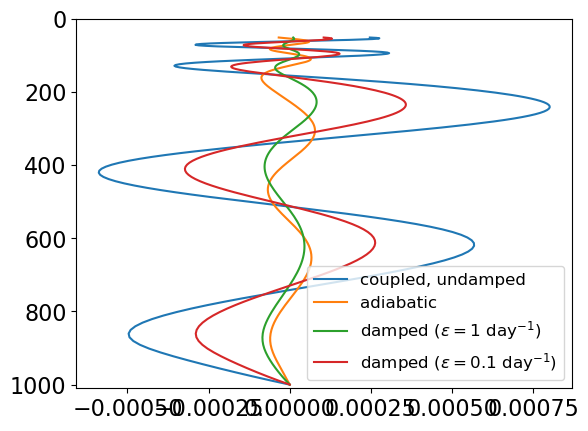

In [18]:
plt.plot(np.real(w_sample),z_to_p_standard(zz_full),label='coupled, undamped')
plt.plot(np.real(w_sampleu),z_to_p_standard(zz_full),label='adiabatic')
plt.plot(np.real(w_sample_damped),z_to_p_standard(zz_full),label=r'damped ($\epsilon = 1$ day$^{-1}$)')
plt.plot(np.real(w_sample_smalldamped),z_to_p_standard(zz_full),label=r'damped ($\epsilon = 0.1$ day$^{-1}$)')

plt.ylim(1010,0.)
plt.legend(fontsize=12)

In [68]:
kblow = -1.12e-1

In [69]:
w_sampleu =  gw_mode_forced(zz_full,W10S300.N2TEST_full/U0**2,kblow,hhat0,U0,0.*zz_full)
w_sample,_,_,_,_  = coupled_gw_mode(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,kblow,hhat0,U0,Mkuang2,coupling='full',itp_matrices=None)

In [70]:
w_sample_damped,_,_,_,_  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,kblow,hhat0,U0,3/86400,Mkuang2,coupling='full',itp_matrices=None)

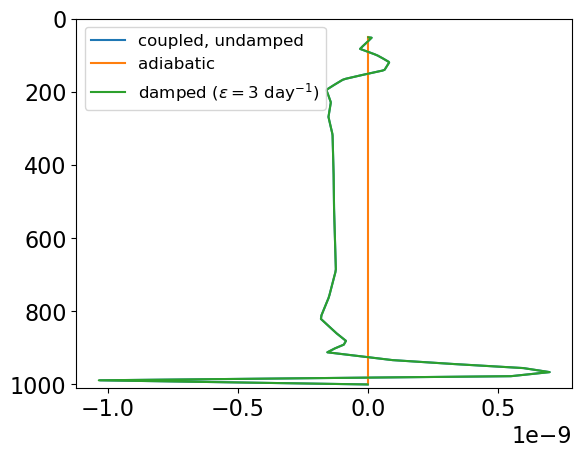

In [71]:
plt.plot(np.real(w_sample),z_to_p_standard(zz_full),label='coupled, undamped')
plt.plot(np.real(w_sampleu),z_to_p_standard(zz_full),label='adiabatic')
plt.plot(np.real(w_sample_damped),z_to_p_standard(zz_full),label=r'damped ($\epsilon = 3$ day$^{-1}$)')

plt.ylim(1010,0.)
plt.legend(fontsize=12)

## Modes that blow up

In [60]:
def mode_ratios(stride=6,start=34,coupling='full',eps=1/86400,MM=Mkuang2):#niter_per_mode=4
    xx ,hx = topographic_profile('cos',A=500)
    xx = xx[2000-start:2000+start+1:stride]
    hx = hx[2000-start:2000+start+1:stride]
    
    kk=k_vector(len(xx),xx[1]-xx[0]); kk[0] = 1e5 # just some dummy nonzero value
    h_hat = np.fft.fft(hx); h_hat[0] = 0.
    ratios  =np.zeros(len(kk))
    ratiosd  =np.zeros(len(kk))
    
    w_hat  =np.zeros((len(kk),len(zz_full)))*1j
    w_hatd  =np.zeros((len(kk),len(zz_full)))*1j
    w_hatu  =np.zeros((len(kk),len(zz_full)))*1j
    Qc_hat  =np.zeros((len(kk),len(zz_full)))*1j
    Qc_hatu  =np.zeros((len(kk),len(zz_full)))*1j
    
    itp1_matrix = np.block([[make_interp_matrix(zz_full,zrce[:26]),np.zeros((26,len(zz_full)))],[np.zeros((14,len(zz_full))),make_interp_matrix(zz_full,zrce[:14])]])
    itp2_matrix = make_interp_matrix(zrce[:26],zz_full)
    itp3_matrix = np.block([[itp2_matrix,np.zeros((len(zz_full),14))],[np.zeros((len(zz_full),26)),make_interp_matrix(zrce[:14],zz_full)]])
    
    for i,k in enumerate(kk):
        if i%10==0:
            print(i,end=' ')
        ww,_,_,Qc,_ = coupled_gw_mode(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,k,h_hat[i],U0,MM,coupling=coupling,itp_matrices = (itp1_matrix,itp2_matrix,itp3_matrix))  #onemode(k,h_hat[i],U0=10.,niter=niter_per_mode)
        wwd,_,_,Qc,_ = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,k,h_hat[i],U0,eps,MM,coupling=coupling,itp_matrices = (itp1_matrix,itp2_matrix,itp3_matrix))  #onemode(k,h_hat[i],U0=10.,niter=niter_per_mode)
        wwu = gw_mode_forced(zz_full,W10S300.N2TEST_full/U0**2,k,h_hat[i],U0,0*zz_full)
        _,_,_,Qcu,_ = coupled_gw_mode(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,k,h_hat[i],U0,MM,coupling='half',itp_matrices = (itp1_matrix,itp2_matrix,itp3_matrix))  #onemode(k,h_hat[i],U0=10.,niter=niter_per_mode)
        
        
        w_hat[i] = ww
        w_hatd[i] = wwd
        w_hatu[i] = wwu
        Qc_hat[i] = Qc
        Qc_hatu[i] = Qcu
        
        ratios[i] = np.sum(np.abs(wwu-ww)**2)/np.sum(np.abs(wwu)**2)
        ratiosd[i] = np.sum(np.abs(wwd-wwu)**2)/np.sum(np.abs(wwu)**2)
        
    w_hat = xr.DataArray(w_hat,coords={'k':kk,'altitude':zz_full/1000},dims=['k','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    w_hatd = xr.DataArray(w_hatd,coords={'k':kk,'altitude':zz_full/1000},dims=['k','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    w_hatu = xr.DataArray(w_hatu,coords={'k':kk,'altitude':zz_full/1000},dims=['k','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    Qc_hat = xr.DataArray(Qc_hat,coords={'k':kk,'altitude':zz_full/1000},dims=['k','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    Qc_hatu = xr.DataArray(Qc_hatu,coords={'k':kk,'altitude':zz_full/1000},dims=['k','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
      
    return kk,ratios,ratiosd,w_hat.sortby('k'),w_hatd.sortby('k'),w_hatu.sortby('k'),Qc_hat.sortby('k'),Qc_hatu.sortby('k') 

In [ ]:
kk_,ratios_,ratiosd_,w_hat_,w_hatd_,w_hatu_,Qc_hat_,Qc_hatu_ = mode_ratios(start=500,stride=6,coupling='full')


In [55]:
xx ,hx = topographic_profile('cos',A=500)
kk_f=k_vector(len(xx),xx[1]-xx[0])
h_hat_f = np.fft.fft(hx)

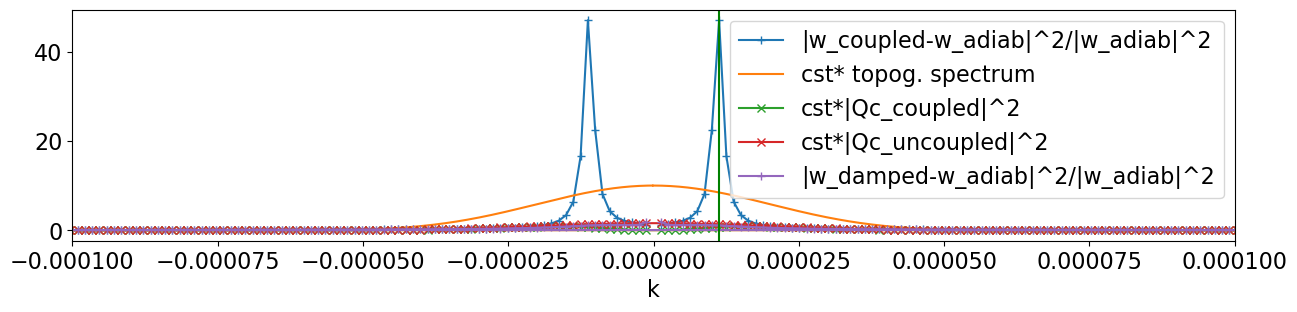

In [56]:
plt.figure(figsize=(15,3))
plt.plot(kk_,ratios_,'-+',label="|w_coupled-w_adiab|^2/|w_adiab|^2")
plt.plot(kk_f,np.abs(h_hat_f)**2/1e7,label="cst* topog. spectrum")
(10000000*np.abs(Qc_hat_)**2).mean('altitude')[:-1].plot(marker = 'x',label="cst*|Qc_coupled|^2")
(10000000*np.abs(Qc_hatu_)**2).mean('altitude')[:-1].plot(marker = 'x',label="cst*|Qc_uncoupled|^2")

plt.plot(kk_,ratiosd_,'-+',label="|w_damped-w_adiab|^2/|w_adiab|^2")


plt.axvline(1.12e-5,color='g')
plt.xlim(-1e-4,1e-4)
plt.legend()

In [61]:
_,_,ratiosd3_,_,_,_,_,_ = mode_ratios(start=500,stride=6,coupling='full',eps=3/86400)
 

0 

/tmp/ipykernel_32749/2448060954.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratios[i] = np.sum(np.abs(wwu-ww)**2)/np.sum(np.abs(wwu)**2)
/tmp/ipykernel_32749/2448060954.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ratiosd[i] = np.sum(np.abs(wwd-wwu)**2)/np.sum(np.abs(wwu)**2)


10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 

In [63]:
_,_,ratiosd0p1_,_,_,_,_,_ = mode_ratios(start=500,stride=6,coupling='full',eps=1/10/86400)
 

0 

/tmp/ipykernel_32749/2448060954.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratios[i] = np.sum(np.abs(wwu-ww)**2)/np.sum(np.abs(wwu)**2)
/tmp/ipykernel_32749/2448060954.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ratiosd[i] = np.sum(np.abs(wwd-wwu)**2)/np.sum(np.abs(wwu)**2)


10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 

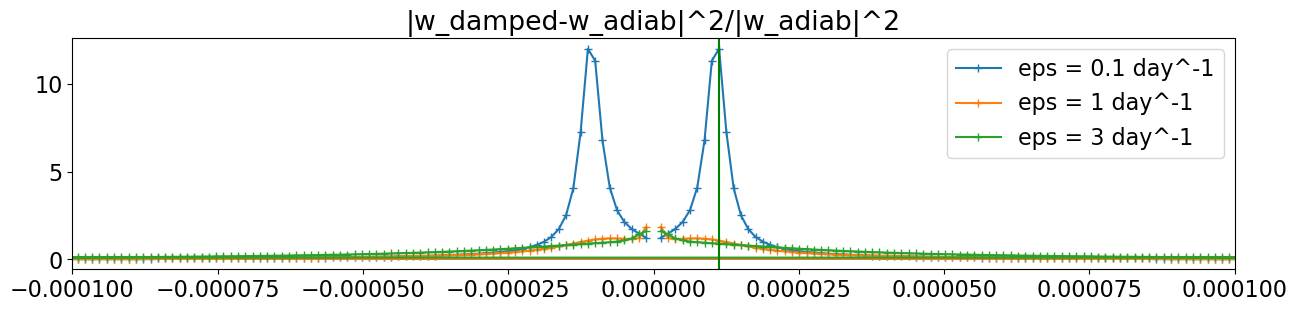

In [68]:
plt.figure(figsize=(15,3))

plt.plot(kk_,ratiosd0p1_,'-+',label="eps = 0.1 day^-1")
plt.plot(kk_,ratiosd_   ,'-+',label="eps = 1 day^-1")
plt.plot(kk_,ratiosd3_  ,'-+',label="eps = 3 day^-1")

plt.title("|w_damped-w_adiab|^2/|w_adiab|^2")

plt.axvline(1.12e-5,color='g')
plt.xlim(-1e-4,1e-4)
plt.legend()

Text(0.5, 1.0, 'Spectrum of LRF and resonant frequency')

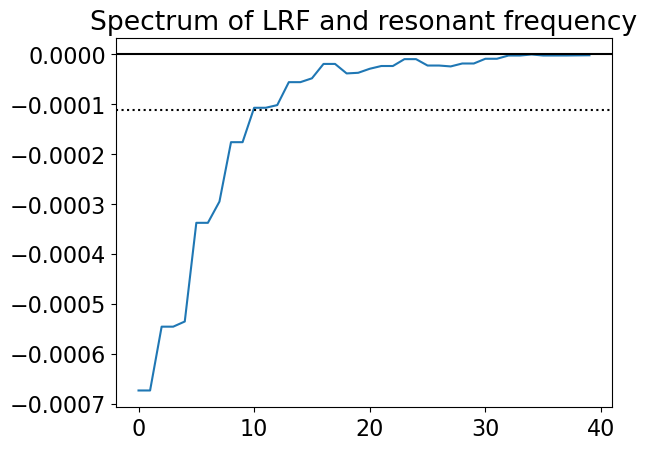

In [127]:
lambdas,_ = spl.eig(Mkuang2/86400)
plt.plot(lambdas)
plt.axhline(0.,color='k')
plt.axhline(-1.12e-5*10,color='k',linestyle=':')
plt.title("Spectrum of LRF and resonant frequency")

## Why some modes resonate

In [108]:
sol_sampleu_1  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,1.2e-5,hhat0/1.2,U0,1/86400/10,0.*Mkuang2,coupling='full',itp_matrices=None)
sol_sampleu_2  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,2e-5,hhat0/2,U0,1/86400/10,0.*Mkuang2,coupling='full',itp_matrices=None)
sol_samplec_1  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,1.2e-5,hhat0/1.2,U0,1/86400/10,Mkuang2,coupling='full',itp_matrices=None)
sol_samplec_2  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,2e-5,hhat0/2,U0,1/86400/10,Mkuang2,coupling='full',itp_matrices=None)

In [109]:
sol_sampleu_0p1  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,1e-7,hhat0*100,U0,1/86400/10,0.*Mkuang2,coupling='full',itp_matrices=None)
sol_samplec_0p1  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,1e-7,hhat0*100,U0,1/86400/10,Mkuang2,coupling='full',itp_matrices=None)


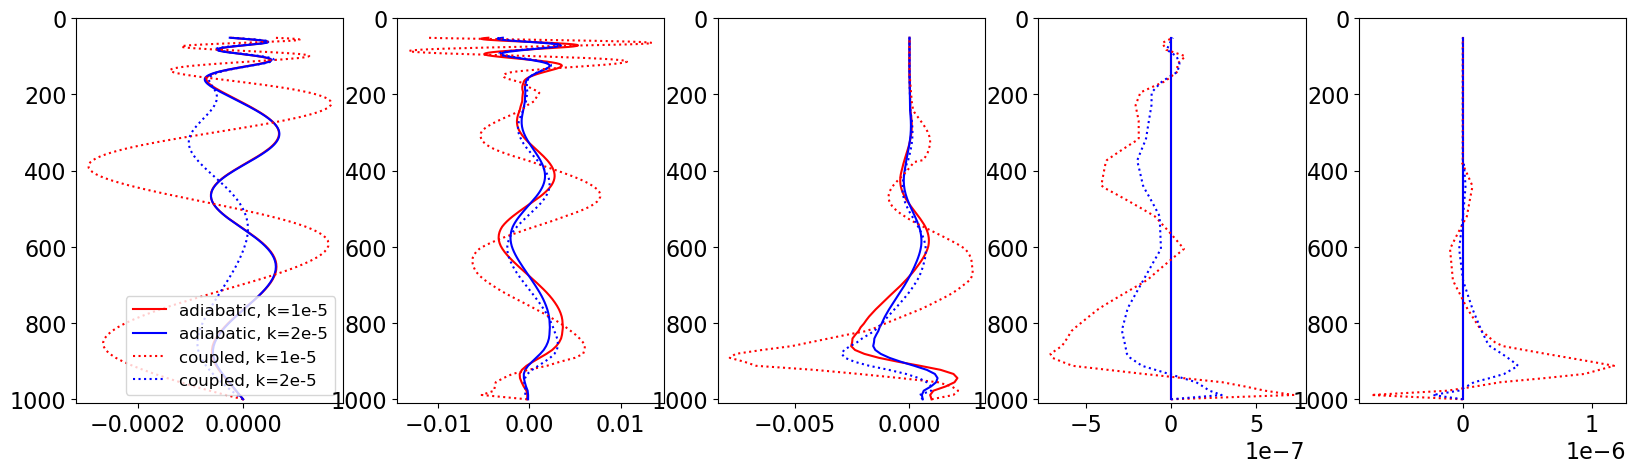

In [117]:
_,axs = plt.subplots(1,5,figsize=(20,5))

for i,ax in enumerate(axs):
    ax.plot(np.real(sol_sampleu_1[i]),z_to_p_standard(zz_full),color='r',label='adiabatic, k=1e-5')
    ax.plot(np.real(sol_sampleu_2[i]),z_to_p_standard(zz_full),color='b',label='adiabatic, k=2e-5')
    ax.plot(np.real(sol_samplec_1[i]),z_to_p_standard(zz_full),color='r',linestyle=':',label='coupled, k=1e-5')
    ax.plot(np.real(sol_samplec_2[i]),z_to_p_standard(zz_full),color='b',linestyle=':',label='coupled, k=2e-5')
    ax.set_ylim(1010,0.)
axs[0].legend(fontsize=12)

### Comparing full solutions

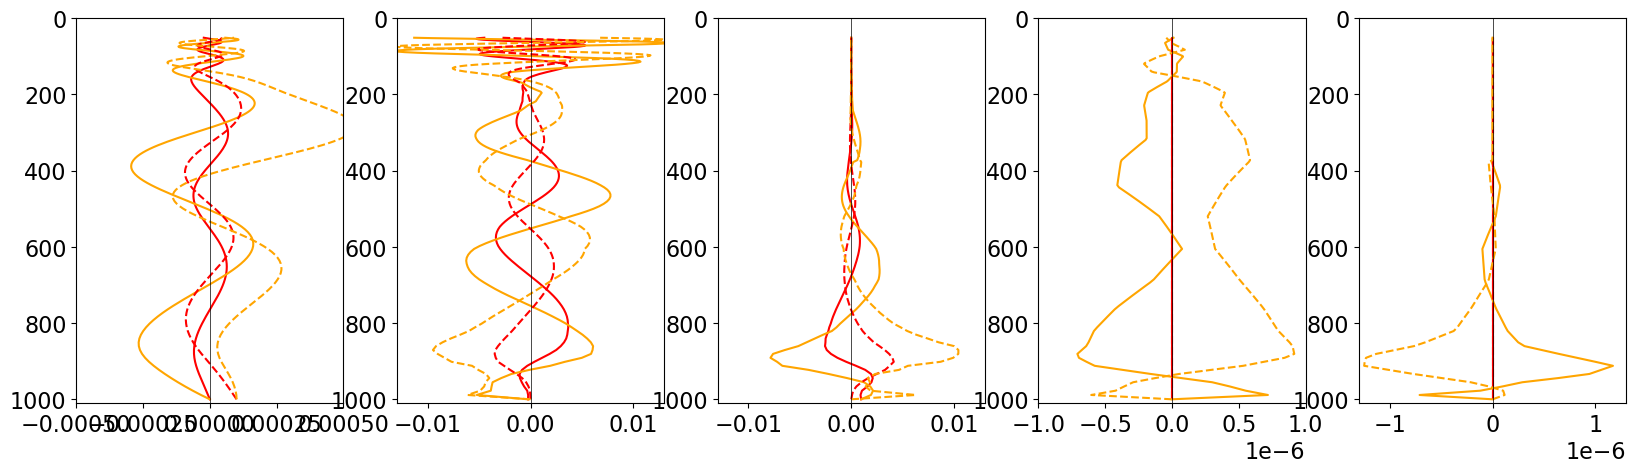

In [115]:
_,axs = plt.subplots(1,5,figsize=(20,5))
lims=[5e-4,1.3e-2,1.3e-2,1e-6,1.3e-6]
for i,ax in enumerate(axs):
    ax.plot(np.real(sol_sampleu_1[i]),z_to_p_standard(zz_full),color='r',label='Re(adiabatic), k=1e-5')
    ax.plot(np.real(sol_samplec_1[i]),z_to_p_standard(zz_full),color='orange',label='Re(coupled), k=1e-5')
    ax.plot(np.imag(sol_sampleu_1[i]),z_to_p_standard(zz_full),linestyle='--',color='r',label='Im(adiabatic), k=1e-5')
    ax.plot(np.imag(sol_samplec_1[i]),z_to_p_standard(zz_full),linestyle='--',color='orange',label='Im(coupled), k=1e-5')
    ax.set_ylim(1010,0.)
    ax.set_xlim(-lims[i],lims[i])
    ax.axvline(0.,color='k',linewidth=0.5)
#axs[0].legend(fontsize=12)

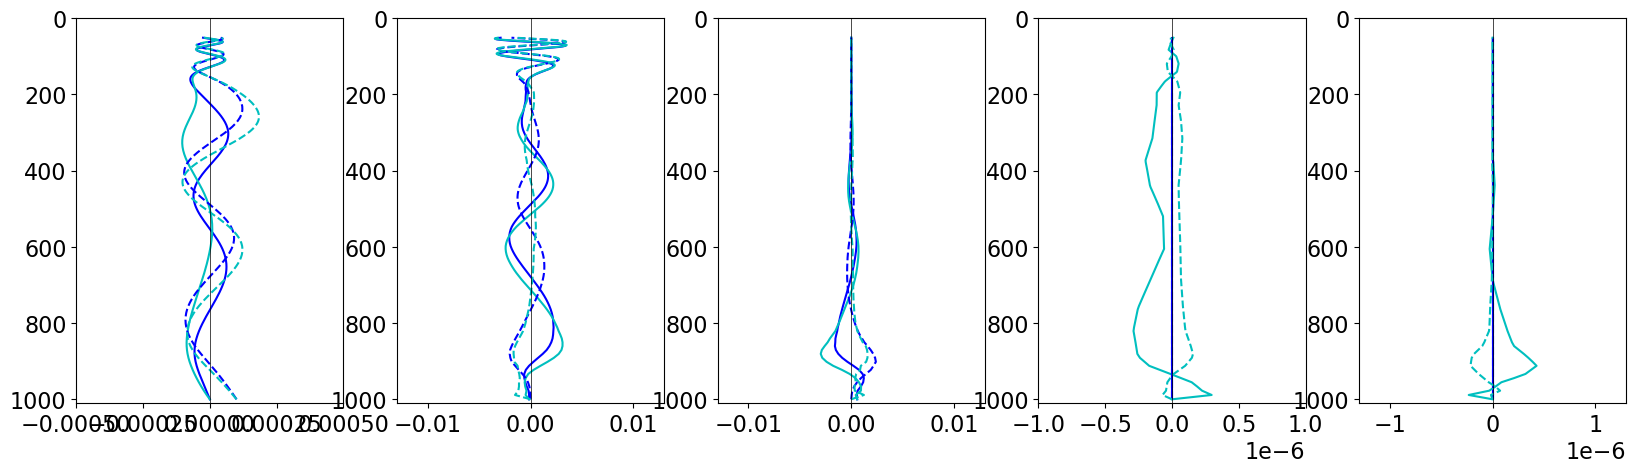

In [116]:
_,axs = plt.subplots(1,5,figsize=(20,5))

for i,ax in enumerate(axs):
    ax.plot(np.real(sol_sampleu_2[i]),z_to_p_standard(zz_full),color='b',label='Re(adiabatic), k=1e-5')
    ax.plot(np.real(sol_samplec_2[i]),z_to_p_standard(zz_full),color='c',label='Re(coupled), k=1e-5')
    ax.plot(np.imag(sol_sampleu_2[i]),z_to_p_standard(zz_full),linestyle='--',color='b',label='Im(adiabatic), k=1e-5')
    ax.plot(np.imag(sol_samplec_2[i]),z_to_p_standard(zz_full),linestyle='--',color='c',label='Im(coupled), k=1e-5')
    ax.set_ylim(1010,0.)
    ax.set_xlim(-lims[i],lims[i])
    ax.axvline(0.,color='k',linewidth=0.5)
#axs[0].legend(fontsize=12)

### small ks

In [122]:
sol_sampleu_1_nodamp  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,1.2e-5,hhat0/1.2,U0,0./86400,0.*Mkuang2,coupling='full',itp_matrices=None)
sol_samplec_1_nodamp  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,1.2e-5,hhat0/1.2,U0,0./86400,Mkuang2,coupling='full',itp_matrices=None)

sol_sampleu_0p1_nodamp  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,1e-6,hhat0*10,U0,0./86400,0.*Mkuang2,coupling='full',itp_matrices=None)
sol_samplec_0p1_nodamp  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,1e-6,hhat0*10,U0,0./86400,Mkuang2,coupling='full',itp_matrices=None)


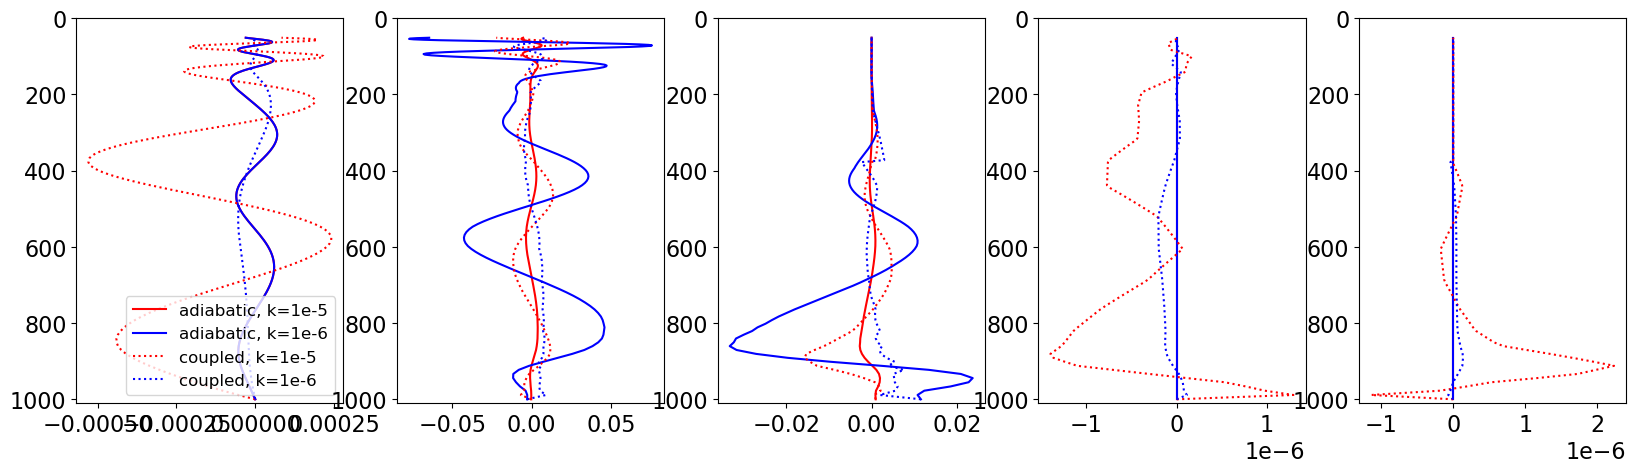

In [123]:
_,axs = plt.subplots(1,5,figsize=(20,5))

for i,ax in enumerate(axs):
    ax.plot(np.real(sol_sampleu_1_nodamp[i]),z_to_p_standard(zz_full),color='r',label='adiabatic, k=1e-5')
    ax.plot(np.real(sol_sampleu_0p1_nodamp[i]),z_to_p_standard(zz_full),color='b',label='adiabatic, k=1e-6')
    ax.plot(np.real(sol_samplec_1_nodamp[i]),z_to_p_standard(zz_full),color='r',linestyle=':',label='coupled, k=1e-5')
    ax.plot(np.real(sol_samplec_0p1_nodamp[i]),z_to_p_standard(zz_full),color='b',linestyle=':',label='coupled, k=1e-6')
    ax.set_ylim(1010,0.)
axs[0].legend(fontsize=12)

# Full damping treatment

## Full coupling

In [11]:
def sum_sol(stride=6,start=34,coupling='full',MM=Mkuang2,eps=1/86400,Sim=W10S300):#niter_per_mode=4
    xx ,hx = topographic_profile('cos',A=500)
    xx = xx[2000-start:2000+start+1:stride]
    hx = hx[2000-start:2000+start+1:stride]
    
    kk=k_vector(len(xx),xx[1]-xx[0]); kk[0] = 1e5 # just some dummy nonzero value
    h_hat = np.fft.fft(hx); h_hat[0] = 0.
    w_hat  =np.zeros((len(kk),len(zz_full)))*1j
    T_hat  =np.zeros((len(kk),len(zz_full)))*1j
    q_hat  =np.zeros((len(kk),len(zz_full)))*1j
    Qc_hat =np.zeros((len(kk),len(zz_full)))*1j
    Qq_hat =np.zeros((len(kk),len(zz_full)))*1j
    
    itp1_matrix = np.block([[make_interp_matrix(zz_full,zrce[:26]),np.zeros((26,len(zz_full)))],[np.zeros((14,len(zz_full))),make_interp_matrix(zz_full,zrce[:14])]])
    itp2_matrix = make_interp_matrix(zrce[:26],zz_full)
    itp3_matrix = np.block([[itp2_matrix,np.zeros((len(zz_full),14))],[np.zeros((len(zz_full),26)),make_interp_matrix(zrce[:14],zz_full)]])
    
    for i,k in enumerate(kk):
        if i%10==0:
            print(i,end=' ')
        ww,Tprime,qprime,Qc,Qq = coupled_gw_mode_damped(zz_full,zrce,Sim.N2TEST_full*T0/g,Sim.dqdz_full,k,h_hat[i],U0,eps,MM,coupling=coupling,itp_matrices = (itp1_matrix,itp2_matrix,itp3_matrix))  #onemode(k,h_hat[i],U0=10.,niter=niter_per_mode)
        w_hat [i] = ww
        T_hat [i] = Tprime
        q_hat [i] = qprime 
        Qc_hat[i] = Qc 
        Qq_hat[i] = Qq 
        
    ww     = xr.DataArray(np.real(np.fft.ifft(w_hat ,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    Tprime = xr.DataArray(np.real(np.fft.ifft(T_hat ,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    qprime = xr.DataArray(np.real(np.fft.ifft(q_hat ,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    Qc     = xr.DataArray(np.real(np.fft.ifft(Qc_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    Qq     = xr.DataArray(np.real(np.fft.ifft(Qq_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    return ww    ,Tprime,qprime,Qc    ,Qq   



 

In [12]:
%time ww_long_eps1,T_long_eps1,q_long_eps1,Qc_long_eps1,_ = sum_sol(start=500,stride=2,coupling='full',eps=1/86400)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 34.7 s, sys: 7.28 s, total: 41.9 s
Wall time: 21.1 s


In [15]:
%time ww_long_eps1_coarse,T_long_eps1_coarse,q_long_eps1_coarse,Qc_long_eps1_coarse,_ = sum_sol(start=100,stride=6,coupling='full',eps=1/86400)

0 10 20 30 CPU times: user 2.4 s, sys: 489 ms, total: 2.89 s
Wall time: 1.51 s


In [18]:
%time ww_long_eps1_coarse_short,T_long_eps1_coarse_short,q_long_eps1_coarse_short,Qc_long_eps1_coarse_short,_ = sum_sol(start=50,stride=6,coupling='full',eps=1/86400)

0 10 CPU times: user 1.29 s, sys: 248 ms, total: 1.54 s
Wall time: 832 ms


In [28]:
Mexp = np.exp(Mkuang2/24) - np.eye(len(Mkuang2))*24
%time _,_,_,Qc_long_eps1_coarse2,_ = sum_sol(start=300,stride=6,coupling='full',eps=1/86400,MM=Mexp)

0 10 20 30 40 50 60 70 80 90 100 CPU times: user 6.88 s, sys: 1.48 s, total: 8.36 s
Wall time: 4.24 s


In [19]:
%time ww_long_eps0,_,_,Qc_long_eps0,_ = sum_sol(start=500,stride=2,coupling='full',eps=0.)
%time ww_long_eps01,_,_,Qc_long_eps01,_ = sum_sol(start=500,stride=2,coupling='full',eps=1/86400/10)
%time ww_long_eps10,_,_,Qc_long_eps10,_ = sum_sol(start=500,stride=2,coupling='full',eps=1/86400*10)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 33.6 s, sys: 7 s, total: 40.6 s
Wall time: 20.3 s
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 33.7 s, sys: 6.93 s, total: 40.6 s
Wall time: 20.3 s
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 33.8 s, sys: 7.05 s, total: 40.9 s
Wall time: 20.4 s


(-2000.0, 2000.0)

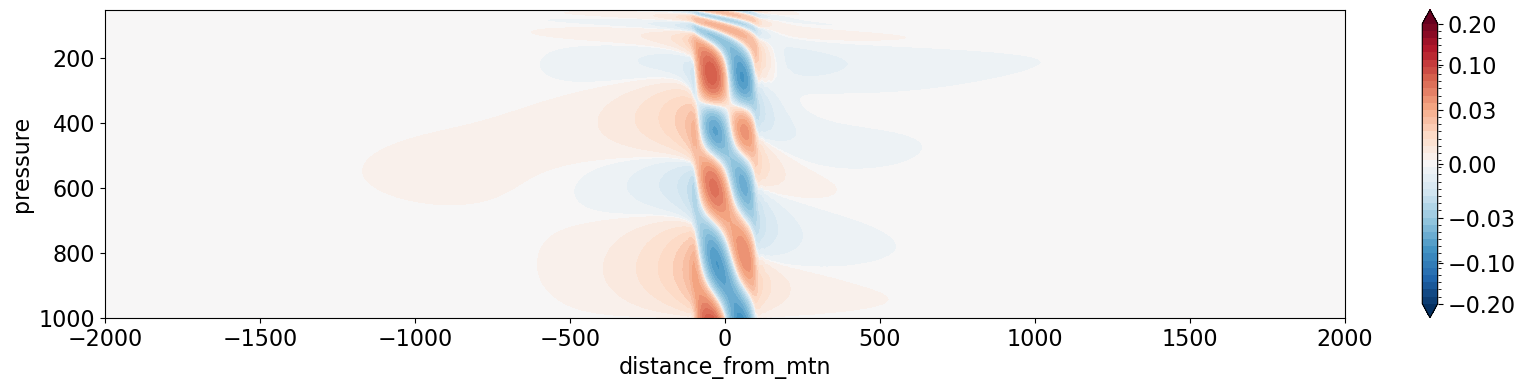

In [52]:
fig,ax = plt.subplots(1,1,figsize=(20,4))
ww_long_eps1.swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})

ax.set_xlim(-2000,2000)

(-2000.0, 2000.0)

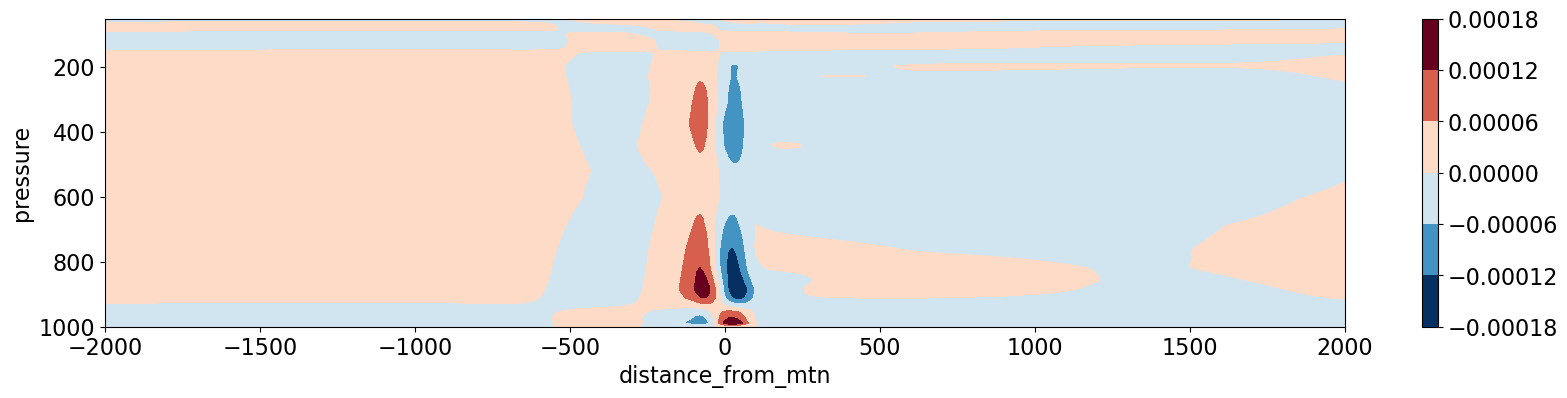

In [22]:
fig,ax = plt.subplots(1,1,figsize=(20,4))
Qc_long_eps1.swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False)

ax.set_xlim(-2000,2000)

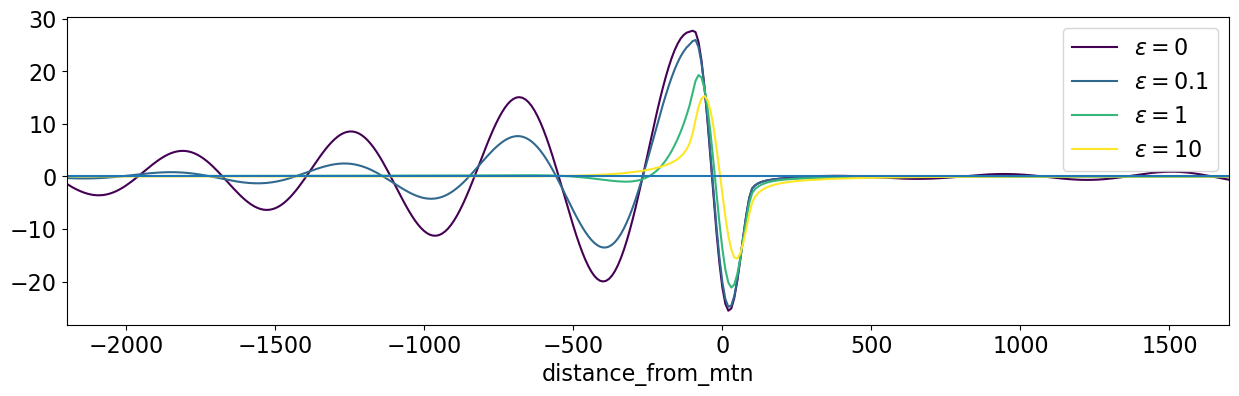

In [226]:
plt.figure(figsize=(15,4))
colors = plt.cm.viridis(np.linspace(0.,1.,4))
for Qc,clr,eps_str in zip((Qc_long_eps0,Qc_long_eps01,Qc_long_eps1,Qc_long_eps10),colors,("0","0.1","1","10")):
    (-Qc.integrate('pressure')*cp/Lv/g*100*86400).plot(label=r"$\epsilon=%s$"%eps_str,color=clr)
plt.xlim(-2200,1700)
plt.axhline(0.)
plt.legend(loc=1)

In [17]:
Qc_long_eps1_coarse.distance_from_mtn

<xarray.DataArray 'distance_from_mtn' (distance_from_mtn: 34)>
array([-500., -470., -440., -410., -380., -350., -320., -290., -260., -230.,
       -200., -170., -140., -110.,  -80.,  -50.,  -20.,   10.,   40.,   70.,
        100.,  130.,  160.,  190.,  220.,  250.,  280.,  310.,  340.,  370.,
        400.,  430.,  460.,  490.])
Coordinates:
  * distance_from_mtn  (distance_from_mtn) float64 -500.0 -470.0 ... 460.0 490.0

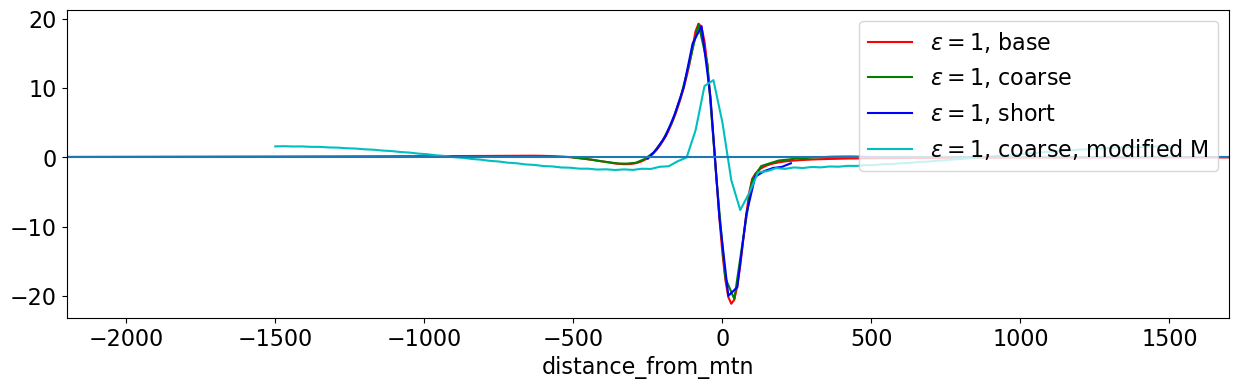

In [29]:
plt.figure(figsize=(15,4))
colors = ('r','g','b','c')
for Qc,clr,eps_str in zip((Qc_long_eps1,Qc_long_eps1_coarse,Qc_long_eps1_coarse_short,Qc_long_eps1_coarse2),colors,("base","coarse",'short','coarse, modified M')):
    (-Qc.integrate('pressure')*cp/Lv/g*100*86400).plot(label=r"$\epsilon=1$, %s"%eps_str,color=clr)
plt.xlim(-2200,1700)
plt.axhline(0.)
plt.legend(loc=1)

## Nonlinear closure, blows up

In [25]:
def linear_w_generalized_forced(xx,hx,z,Uz,Nz,eps,qxz):
    "z must be evenly spaced"
    kk=k_vector(len(xx),xx[1]-xx[0])
    h_hat = np.fft.fft(hx)
    kk[0]=1e-7;h_hat[0] = 0.
    lz2 = Nz**2/Uz**2 - 1/Uz * np.dot(second_derivative_matrix(len(z),z[1]-z[0]),Uz)
    qhatz = np.fft.fft(qxz,axis=0)
    
    w_hat =np.zeros((len(kk),len(z)))*1j
    for i,k in enumerate(kk):
        if i%500==0:
            print(i,end=' ')
        w_hat[i] = gw_mode_forced_damped(z,lz2,k,h_hat[i],Uz[0],eps,qhatz[i,:]/Uz**2)
        
    w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(z))})
    return w

def get_Tqprime(ww,U,eps,dsdz,Q):
    xx = np.array(ww.distance_from_mtn*1e3)
    kk=k_vector(len(xx),xx[1]-xx[0])
    kk=kk+1e-6*(kk==0.)
    w_hat = np.fft.fft(ww,axis=0)
    Q_hat = np.fft.fft(Q,axis=0)
    T_hat = 1/(1j*kk[:,None]*U[None,:] + eps)*(Q_hat - w_hat*dsdz[None,:])
    return np.real(np.fft.ifft(T_hat,axis=0))

def calc_w_general_forced_nonlin(Sim,stride=1,start=1000,eps=1/86400,initsols=None):
    xx ,hx = topographic_profile('cos',A=500)
    xx = xx[2000-start:2000+start+1:stride]
    hx = hx[2000-start:2000+start+1:stride]
    
    z=np.arange(0,20e3,DZ)
    p = interp1d(Sim.Z_PL_SNAP,Sim.Z_PL_SNAP.pressure,kind='linear',fill_value='extrapolate')(z)
    N = interp1d(Sim.Z_PL_SNAP,Sim.N_PL_MEAN,kind='linear',fill_value='extrapolate')(z)
    dqdz = interp1d(Sim.Z_PL_SNAP, np.gradient(W10S300.Q_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S300.Z_PL_SNAP) ,kind='linear',fill_value='extrapolate')(z)
    dsdz = N**2*T0/g
    U0 = 10.
    U = U0*z**0
    
    if initsols==None:
        ww,Tprime,qprime,_,_ = sum_sol(start=start,stride=stride,coupling='full',eps=eps)
    else:
        ww,Tprime,qprime =initsols
    qprime/=1e3
    
    #ww = linear_w_generalized(xx,hx,z,U,N)
    #Tprime = get_Tqprime(ww,U,eps,dsdz,0.*ww)
    #qprime = get_Tqprime(ww,U,eps,dqdz,0.*ww)
    
    MT = make_interp_matrix(z,zrce[:26])
    Mq = make_interp_matrix(z,zrce[:14])
    MTm1 = make_interp_matrix(zrce[:26],z)
    Mqm1 = make_interp_matrix(zrce[:14],z)
    
    for i in range(15):
        print(i)
        Tq_itp = np.concatenate((np.dot(MT,Tprime.T),np.dot(Mq,qprime.T*1e3)),axis=0)
        QcQq_itp = np.dot(Mkuang2,Tq_itp)
        Qc = np.dot(MTm1,QcQq_itp[:26]).T/86400
        Qq = np.dot(Mqm1,QcQq_itp[26:]).T/(86400*1e3)
        #fact = (-np.trapz(Qc,p)*cp/Lv/g*100*86400>-2.)[:,None]
        #Qc = Qc*fact
        #Qq = Qq*fact
        
        rain = -np.trapz(Qc,p,axis=1)*cp/Lv/g*100*86400
        rainthresh=-4
        Qc = Qc * ( (rain<rainthresh)*(rainthresh)/rain + (rain>=rainthresh) )[:,None]
        Qq = Qq * ( (rain<rainthresh)*(rainthresh)/rain + (rain>=rainthresh) )[:,None]
      
        
        #Qc -= Qc.mean(axis=0)
        #Qq -= Qq.mean(axis=0)
        # Qc = max(Qc,0)### First do without it to check previous sol
        # Qq = min(Qq,0)### First do without it to check previous sol
        plt.figure(figsize=(15,3))
        (np.array(Tprime)*ww.assign_coords({'pressure':('altitude',p)}).swap_dims({'altitude':'pressure'})**0).plot(y='pressure',yincrease=False);plt.title('Tprime')
        plt.figure(figsize=(15,3))
        (np.array(qprime)*ww.assign_coords({'pressure':('altitude',p)}).swap_dims({'altitude':'pressure'})**0).plot(y='pressure',yincrease=False);plt.title('qprime')
        plt.figure(figsize=(15,3))
        (86400*Qc*ww.assign_coords({'pressure':('altitude',p)}).swap_dims({'altitude':'pressure'})**0).plot(y='pressure',yincrease=False);plt.title('Qc')
        Tprime = get_Tqprime(ww,U,eps,dsdz,Qc)
        qprime = get_Tqprime(ww,U,eps,dqdz,Qq)
        
    ww = ww.assign_coords({'pressure':('altitude',p)}).swap_dims({'altitude':'pressure'})
    Tprime = ww**0*Tprime
    qprime = ww**0*qprime
    Qc = ww**0*Qc
    Qq = ww**0*Qq
    return ww,Tprime,qprime,Qc,Qq


In [16]:
ww0,Tprime0,qprime0,_,_ = sum_sol(start=500,stride=2,coupling='full',eps=10/86400)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

0
1
2
3
4
5
6


/tmp/ipykernel_234014/1170670476.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,3))


7
8
9
10
11
12
13
14


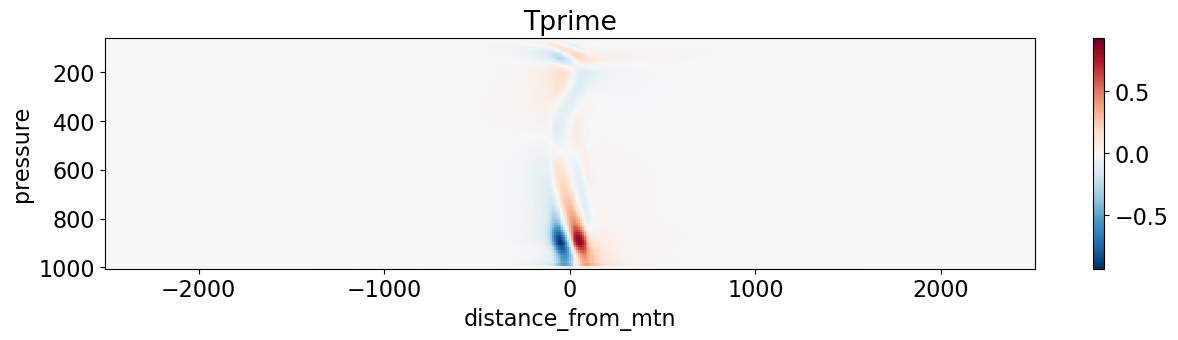

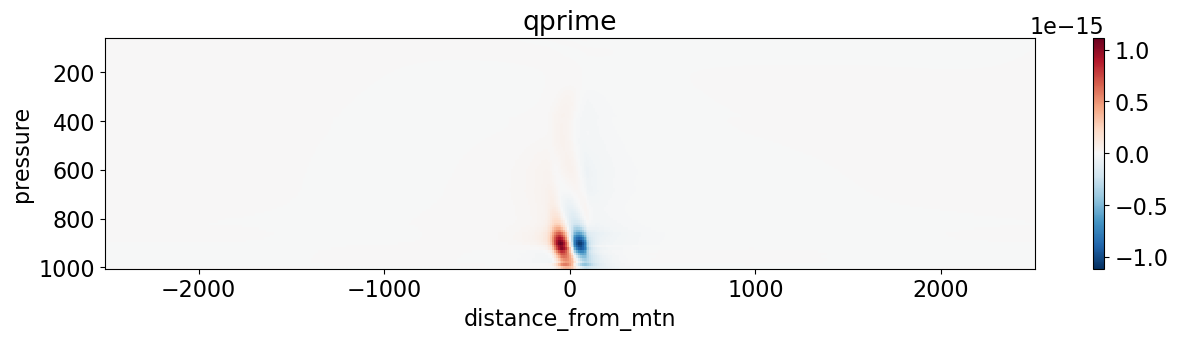

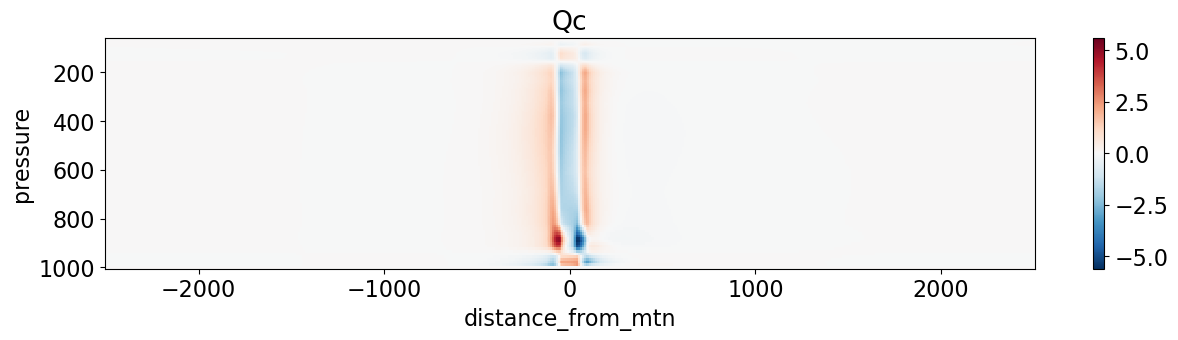

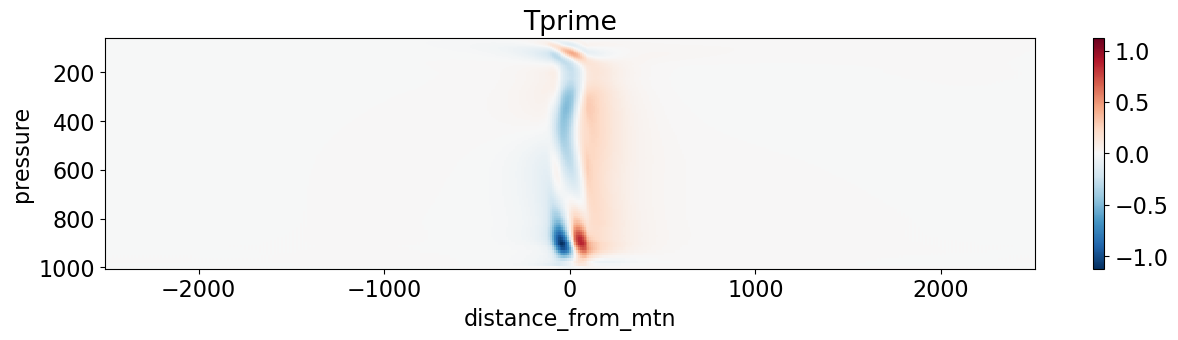

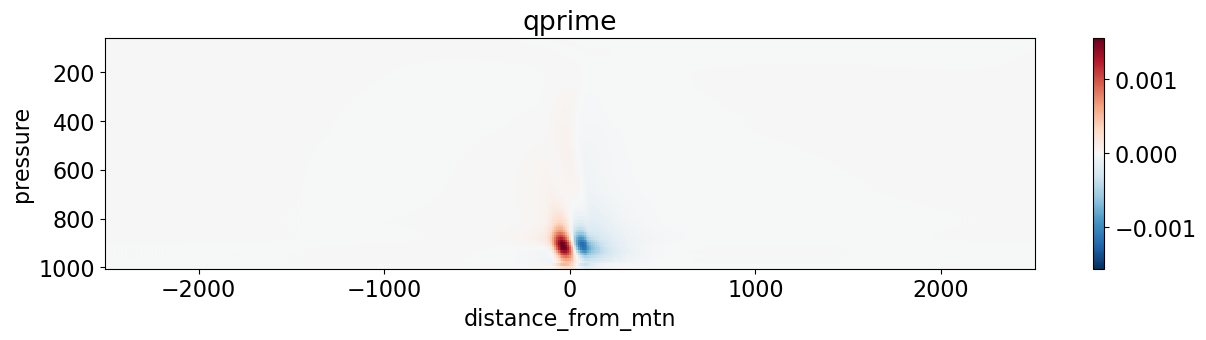

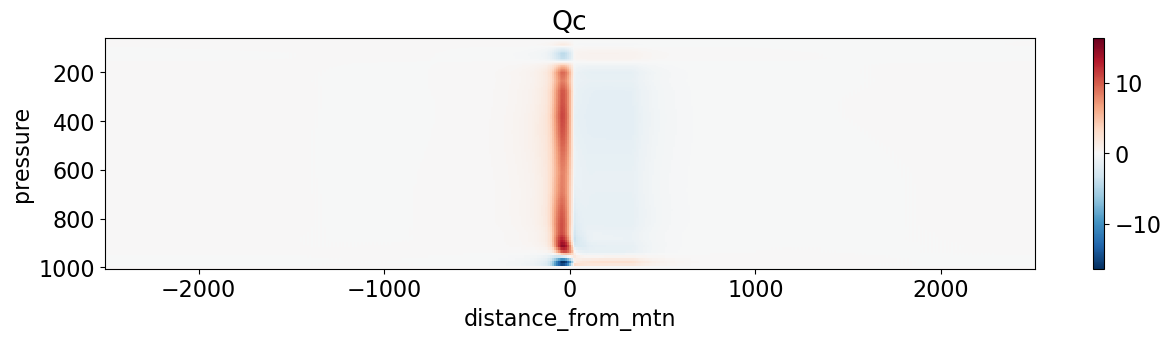

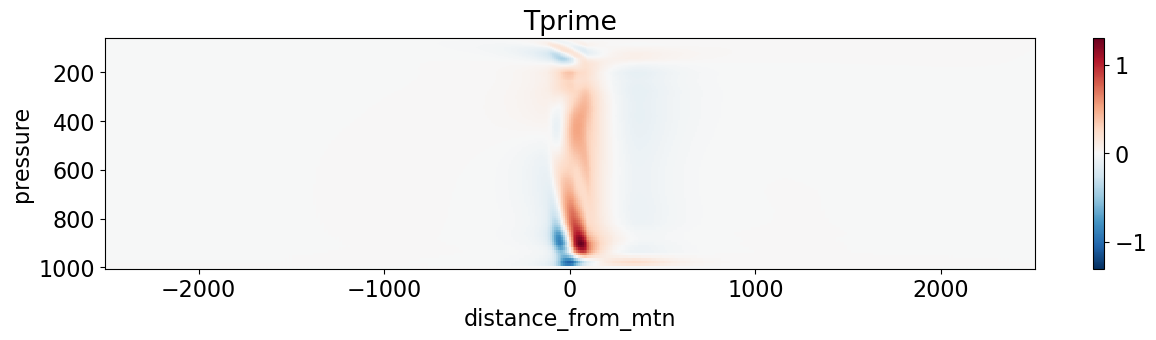

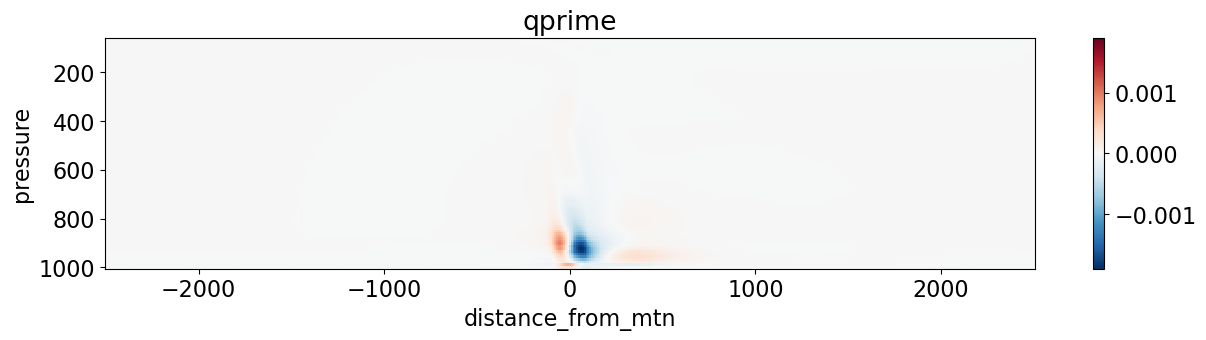

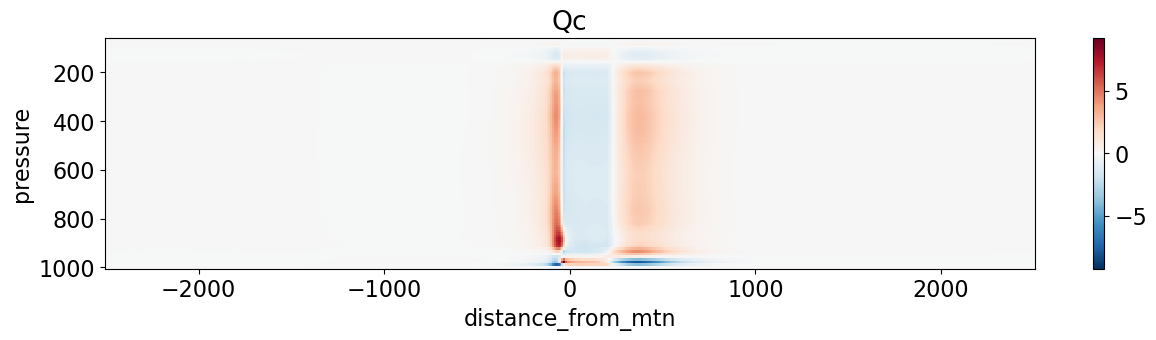

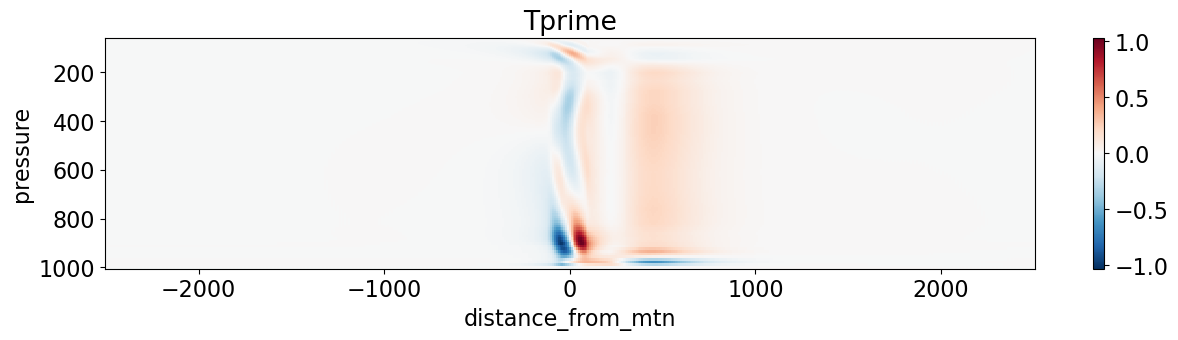

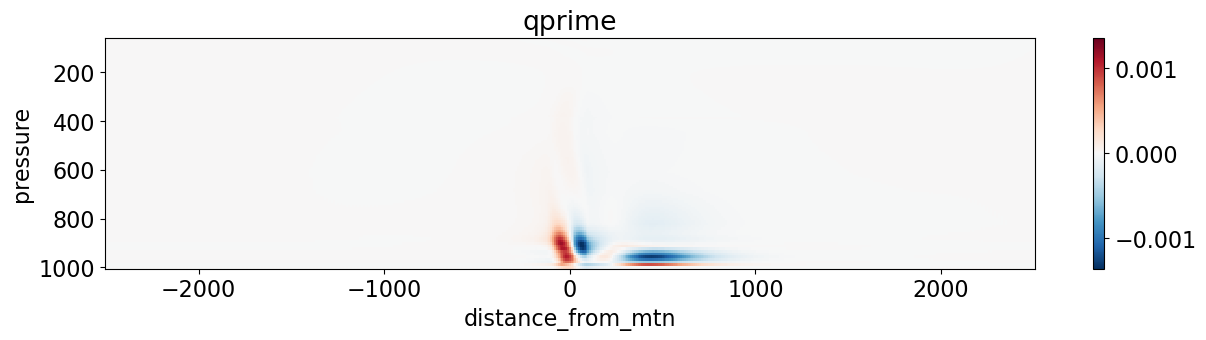

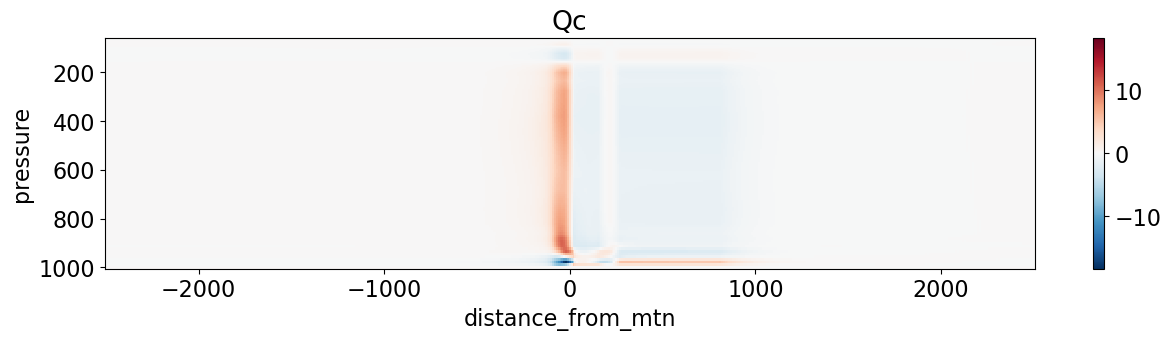

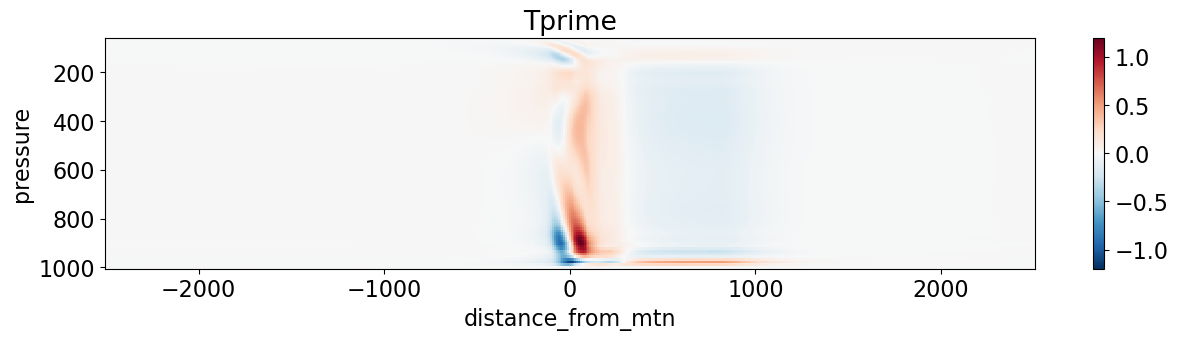

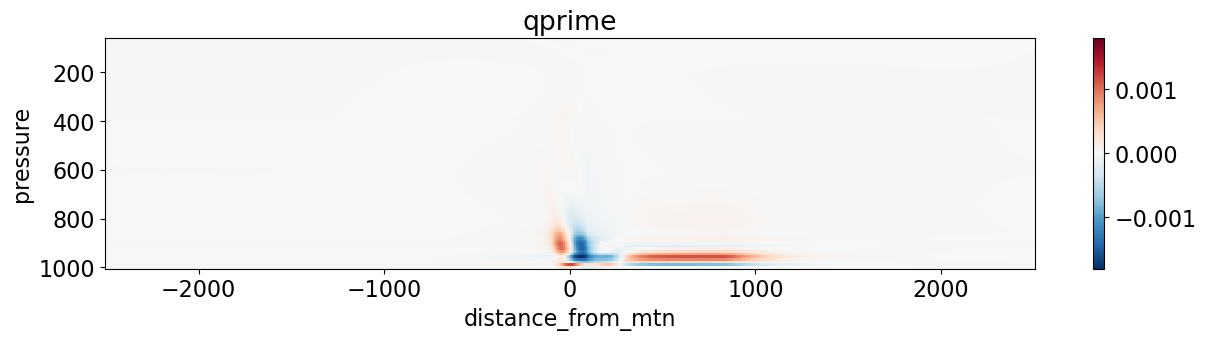

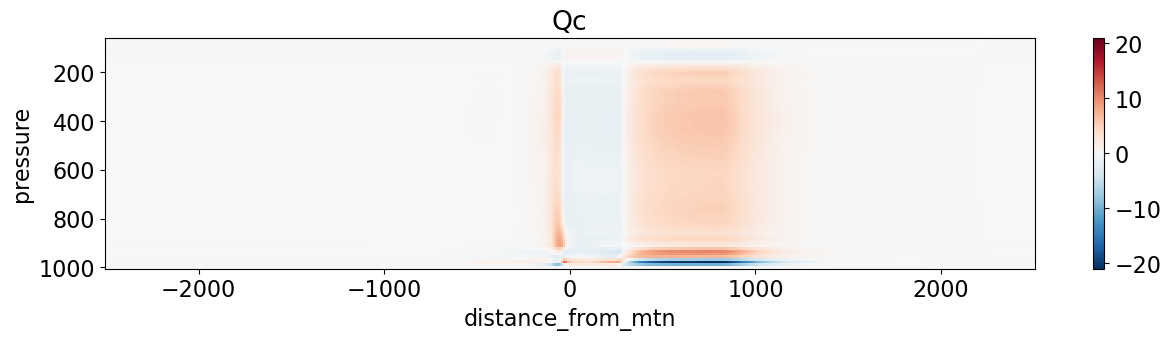

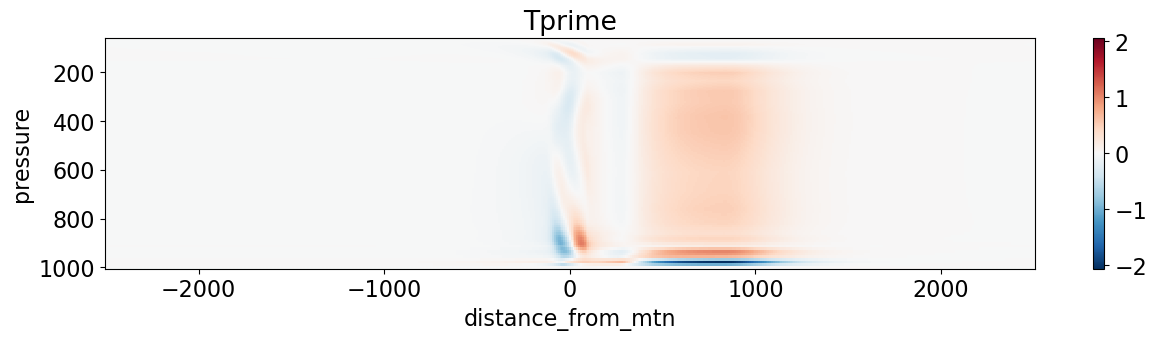

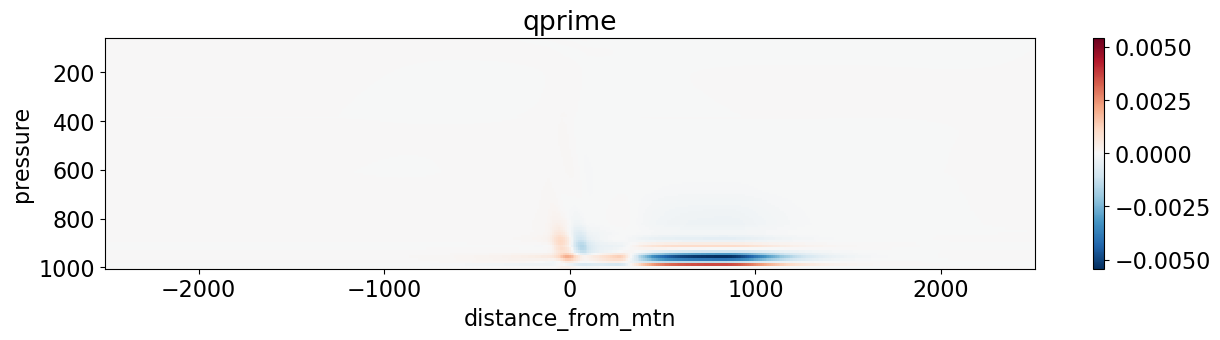

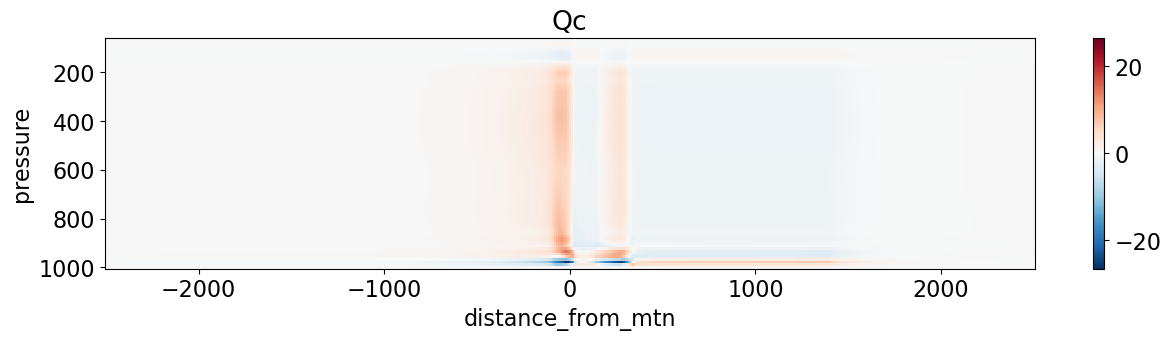

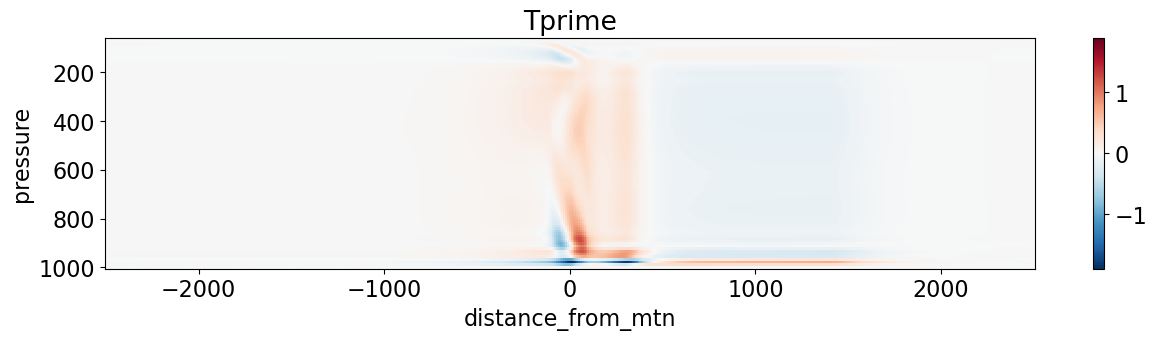

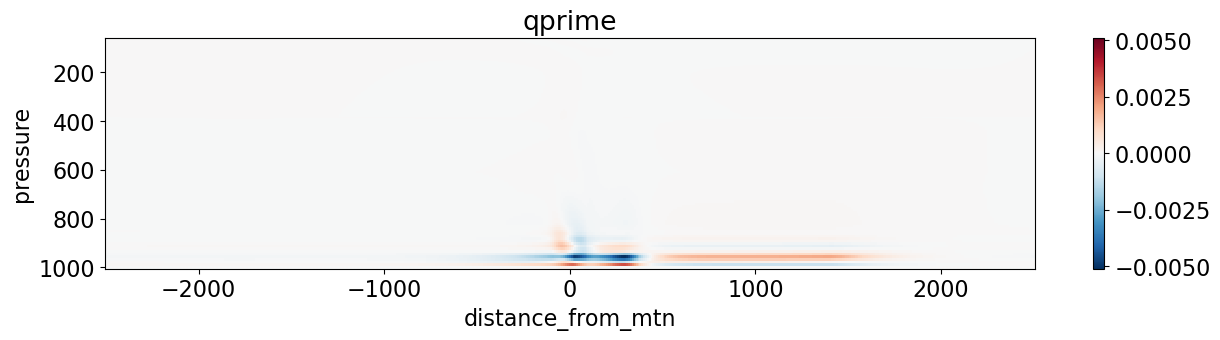

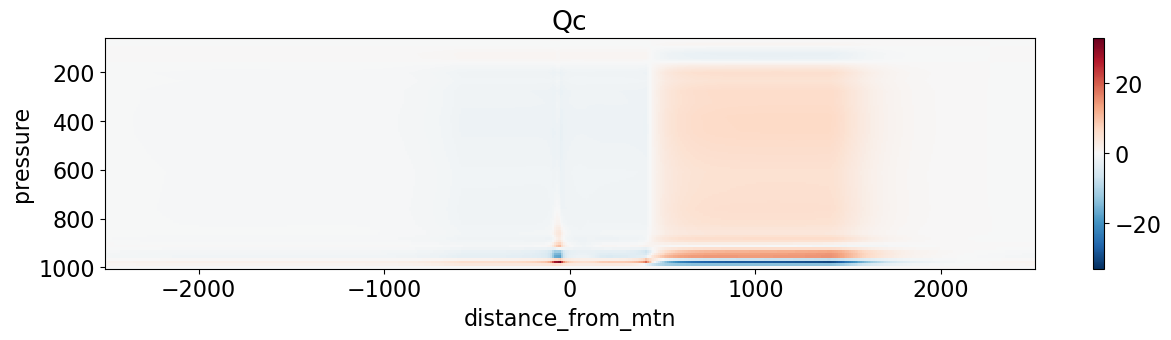

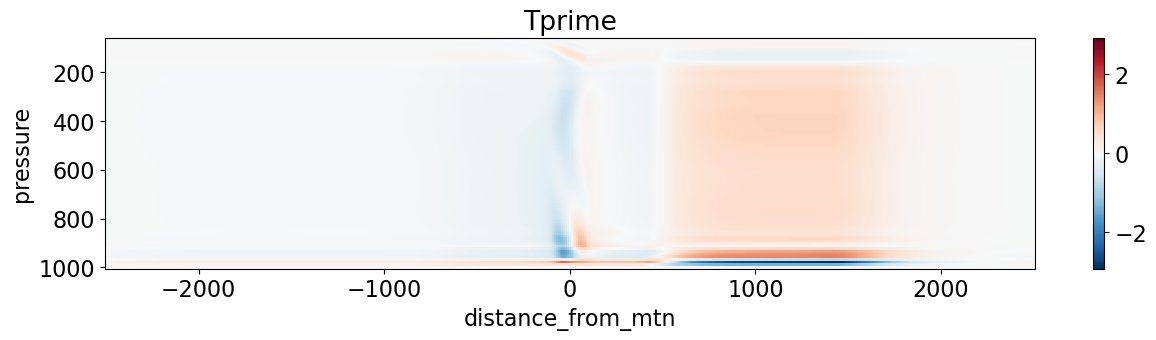

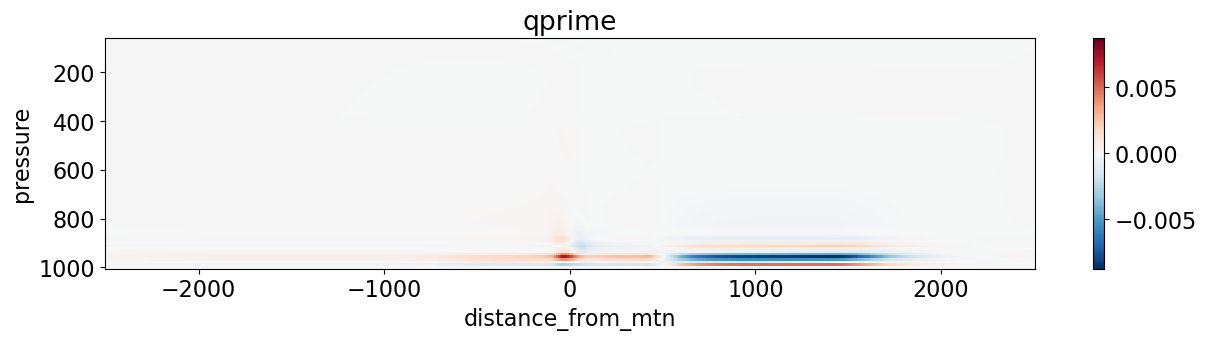

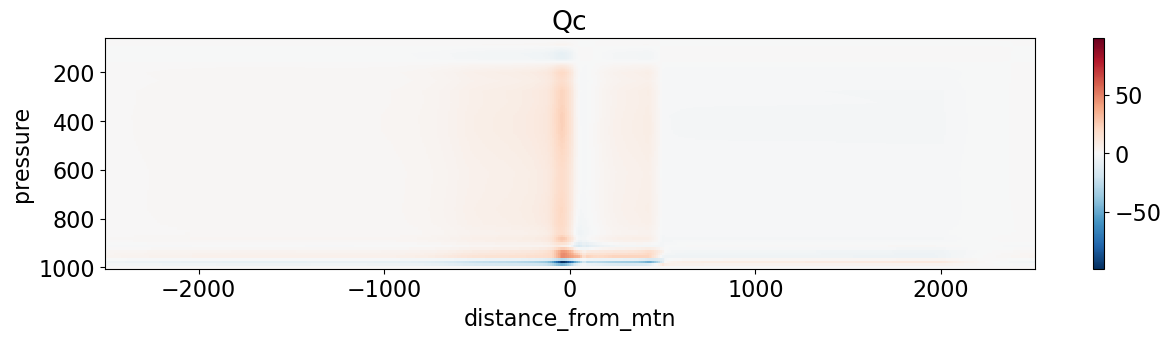

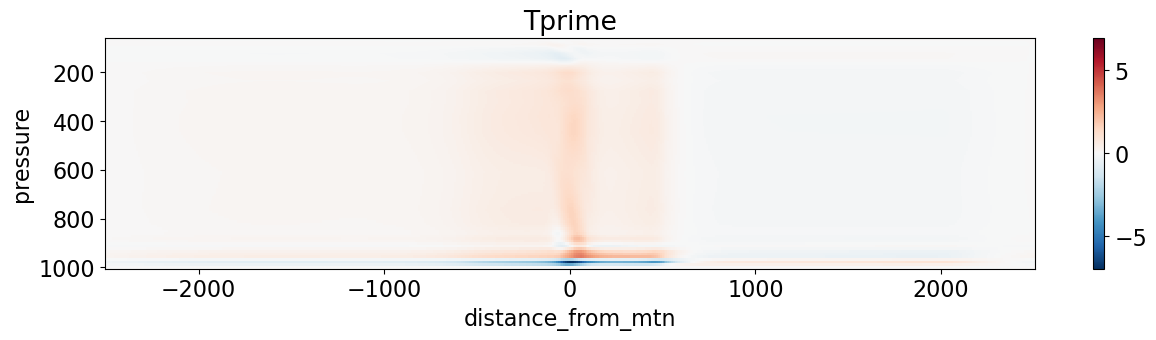

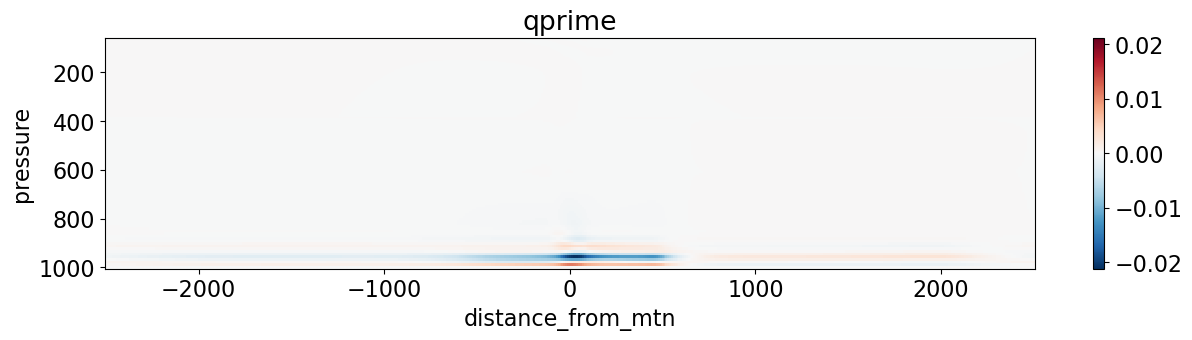

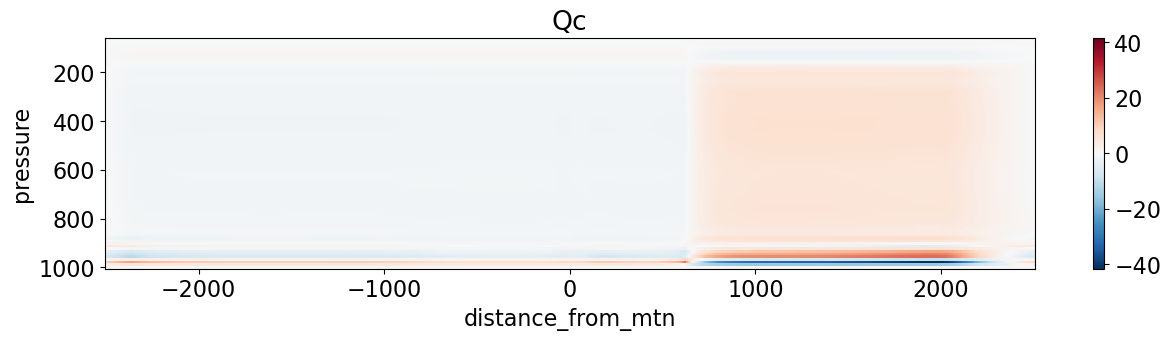

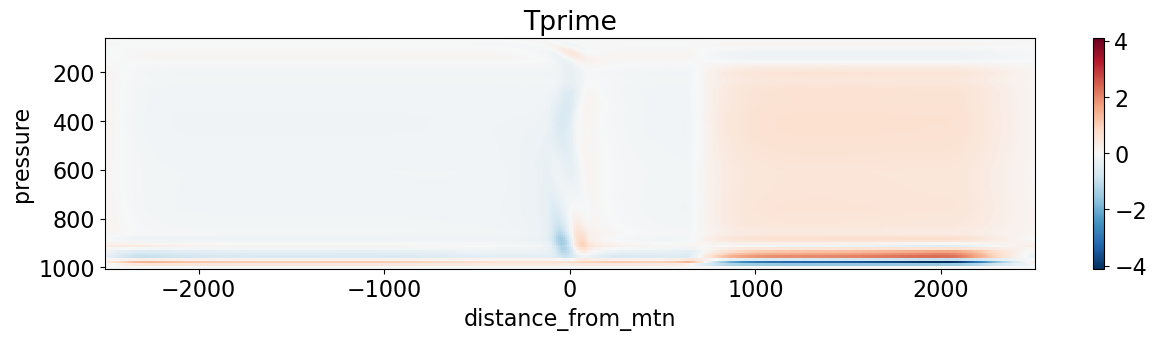

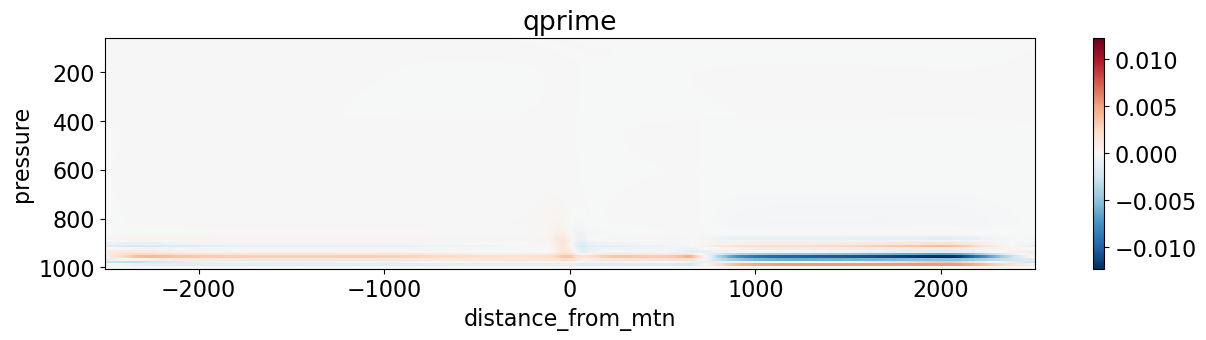

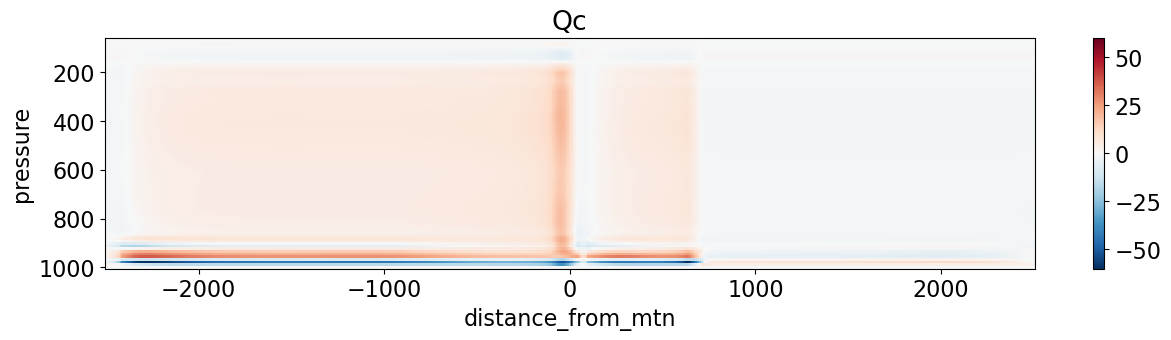

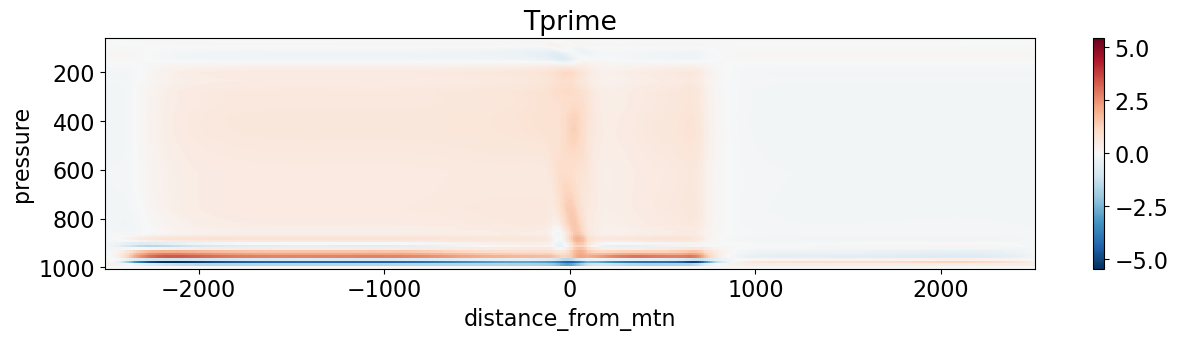

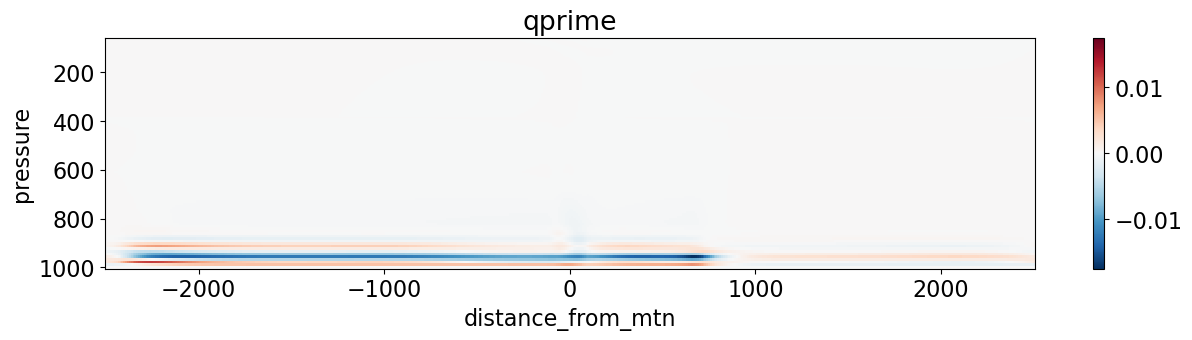

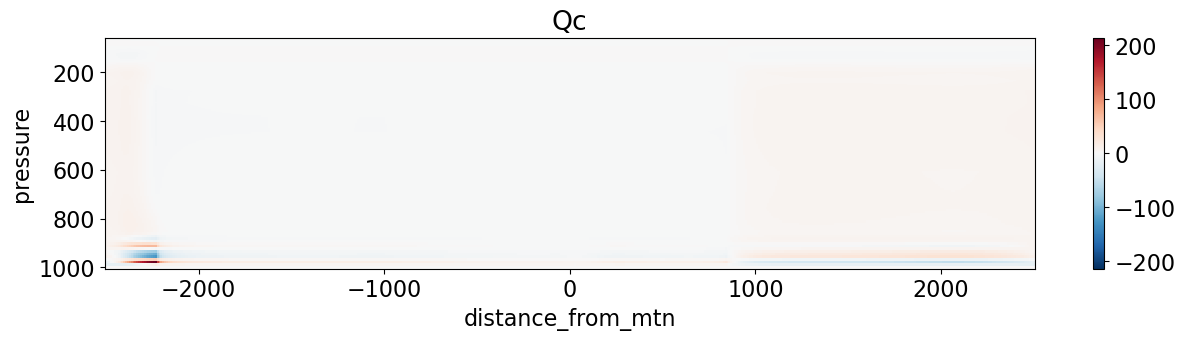

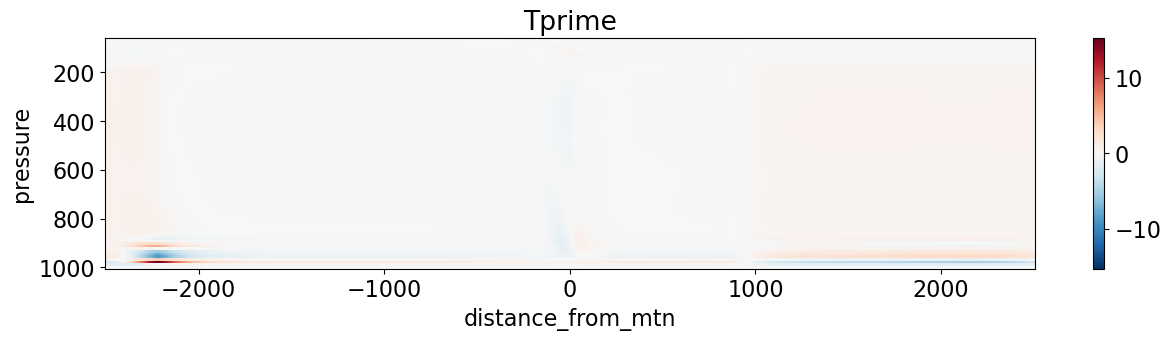

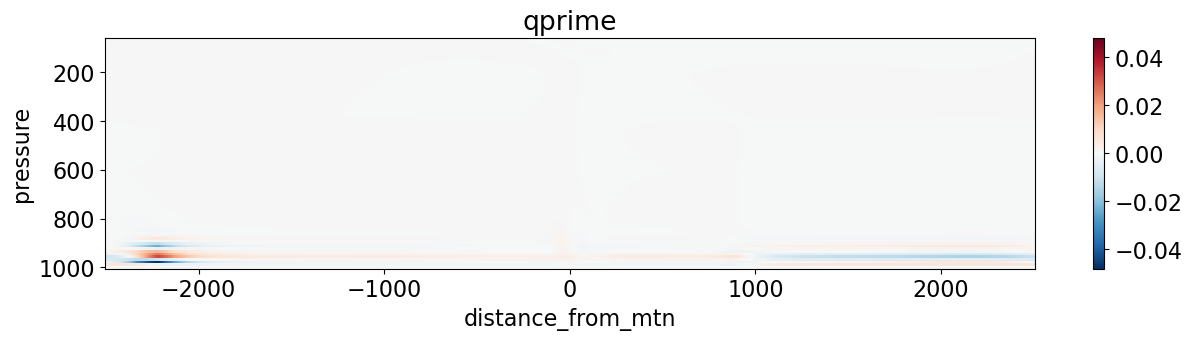

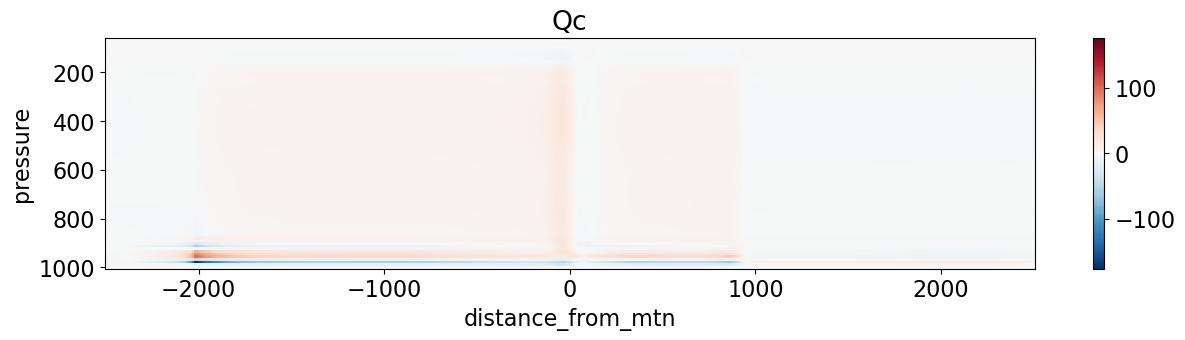

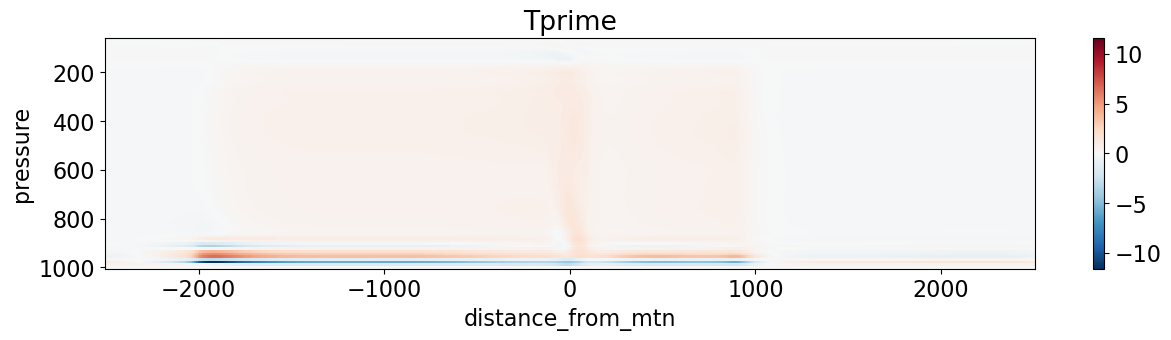

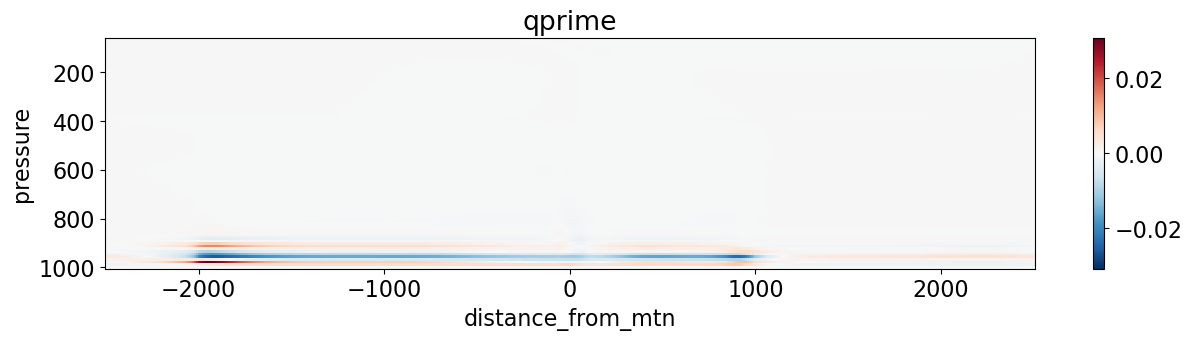

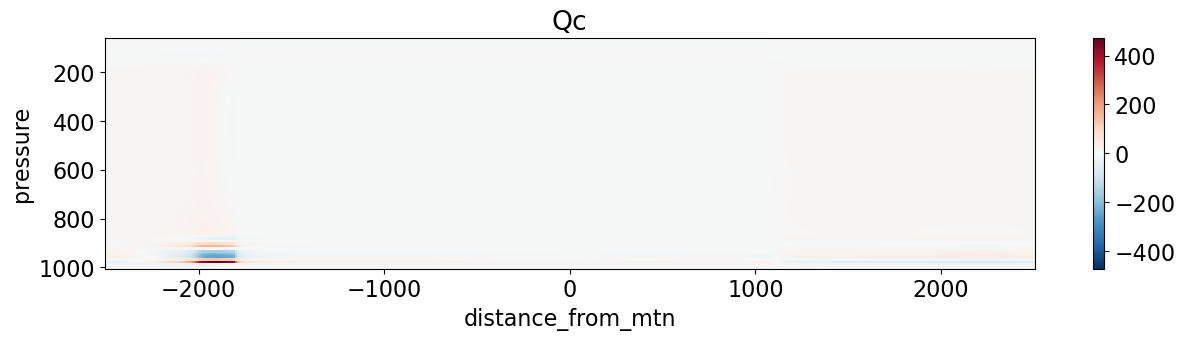

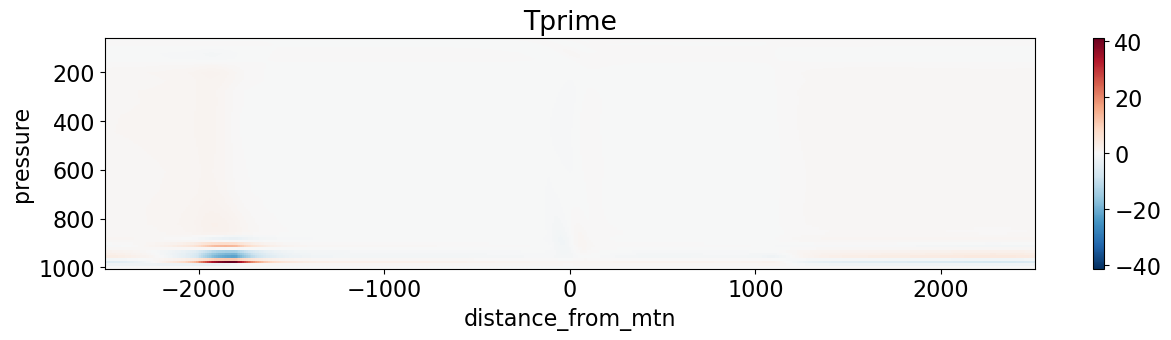

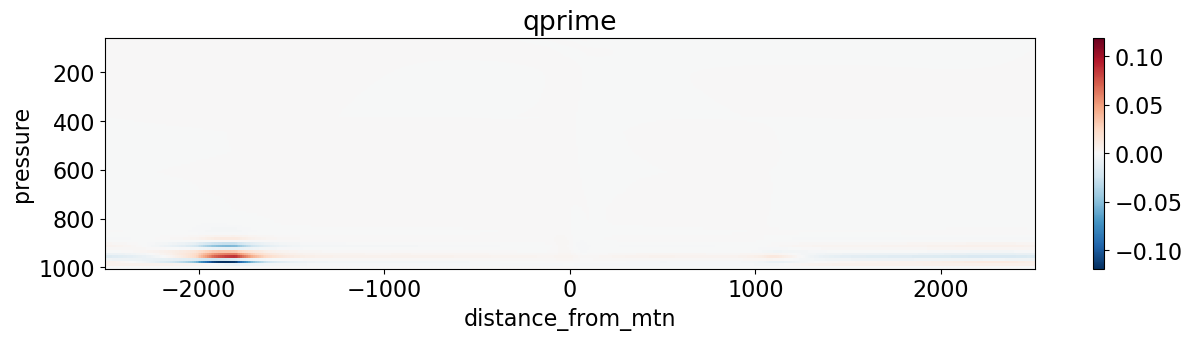

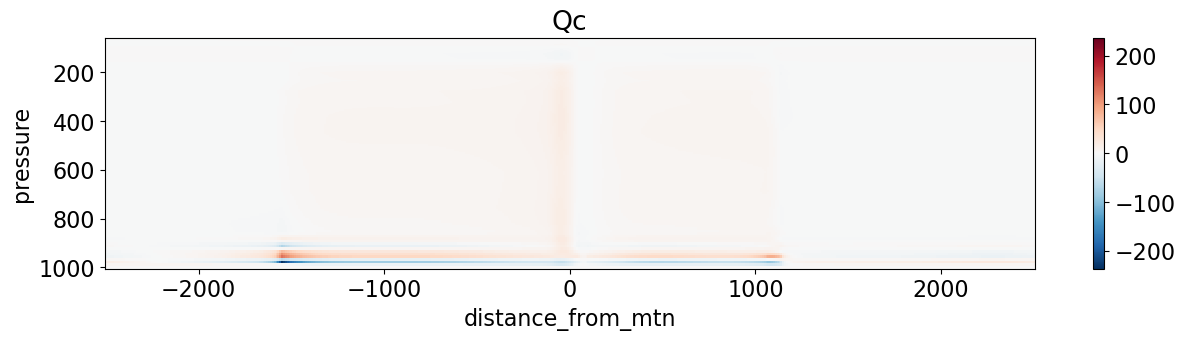

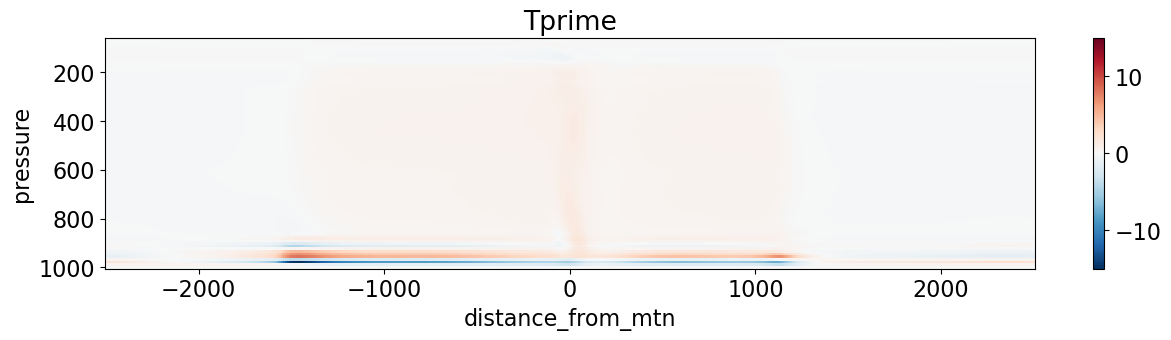

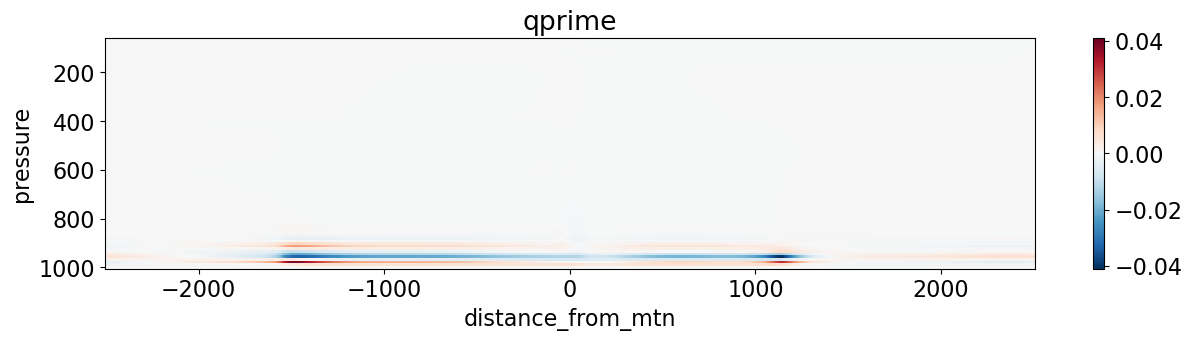

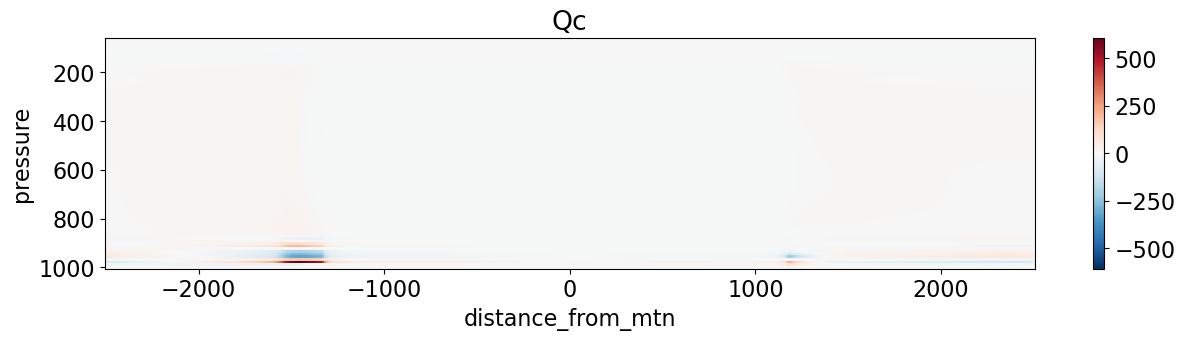

In [26]:
ww_,Tprime_,qprime_,Qc_,Qq_ = calc_w_general_forced_nonlin(W10S300,stride=2,start=500,eps=10/86400,initsols=(ww0,Tprime0,qprime0))

## Nonlinear closure 2

In [14]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

In [15]:
def fun(x,Tq,witpfunc,dsdz,dqdz,MM,p,eps,U0):
    n = len(Tq)//2
    QcQq = np.dot(MM,Tq)
    rain = -np.trapz(QcQq[:n],p)*cp/Lv/g*100*86400
    if rain < -2.:
        QcQq = QcQq*(-2)/rain
    w = witpfunc(x)
    return (QcQq - np.concatenate((w*dsdz,w*dqdz)) - eps*Tq)/U0

def calc_w_general_forced_nonlin(Sim,stride=1,start=1000,eps=1/86400,MM=Mkuang2):
    xx ,hx = topographic_profile('cos',A=500)
    xx = xx[2000-start:2000+start+1:stride]
    hx = hx[2000-start:2000+start+1:stride]
    
    z=np.arange(0,20e3,DZ)
    p = interp1d(Sim.Z_PL_SNAP,Sim.Z_PL_SNAP.pressure,kind='linear',fill_value='extrapolate')(z)
    N = interp1d(Sim.Z_PL_SNAP,Sim.N_PL_MEAN,kind='linear',fill_value='extrapolate')(z)
    dqdz = interp1d(Sim.Z_PL_SNAP, np.gradient(Sim.Q_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),Sim.Z_PL_SNAP) ,kind='linear',fill_value='extrapolate')(z)
    dsdz = N**2*T0/g
    U0 = 10.
    U = U0*z**0
    
    ww,_,_,_,_ = sum_sol(start=start,stride=stride,coupling='full',eps=eps,MM=MM)

    MT = make_interp_matrix(z,zrce[:26])
    Mq = make_interp_matrix(z,zrce[:14])*1e3
    MTm1 = make_interp_matrix(zrce[:26],z)
    Mqm1 = make_interp_matrix(zrce[:14],z)/1e3
    
    itp1_matrix = np.block([[MT,np.zeros((26,len(z)))],[np.zeros((14,len(z))),Mq]])
    itp3_matrix = np.block([[MTm1,np.zeros((len(z),14))],[np.zeros((len(z),26)),Mqm1]])
    MM_itp = np.linalg.multi_dot((itp3_matrix,MM/86400,itp1_matrix))
    
    witpfunc = interp1d(xx,ww,axis=0)
    Tq = solve_ivp(fun,[xx[-0],xx[-1]],np.zeros(2*len(z)),t_eval=xx,args = (witpfunc,dsdz,dqdz,MM_itp,p,eps,U0) ).y

    QcQq = np.dot(MM_itp,Tq)
    rain = -np.trapz(QcQq[:len(z)],p,axis=0)*cp/Lv/g*100*86400
    rainthresh=-4
    QcQq = QcQq * ( (rain<rainthresh)*(rainthresh)/rain + (rain>=rainthresh) )
       
        
    ww = ww.assign_coords({'pressure':('altitude',p)}).swap_dims({'altitude':'pressure'})
    Tprime = ww**0*Tq[:len(z)].T
    qprime = ww**0*Tq[len(z):].T*1e3
    Qc = ww**0*QcQq[:len(z)].T
    Qq = ww**0*QcQq[len(z):].T*1e3
    return ww,Tprime,qprime,Qc,Qq


In [159]:
ww_,Tprime_,qprime_,Qc_,Qq_ = calc_w_general_forced_nonlin(W10S300,stride=2,start=500)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

/tmp/ipykernel_234014/2548933865.py:40: RuntimeWarning: invalid value encountered in divide
  QcQq = QcQq * ( (rain<rainthresh)*(rainthresh)/rain + (rain>=rainthresh) )


(-2000.0, 2000.0)

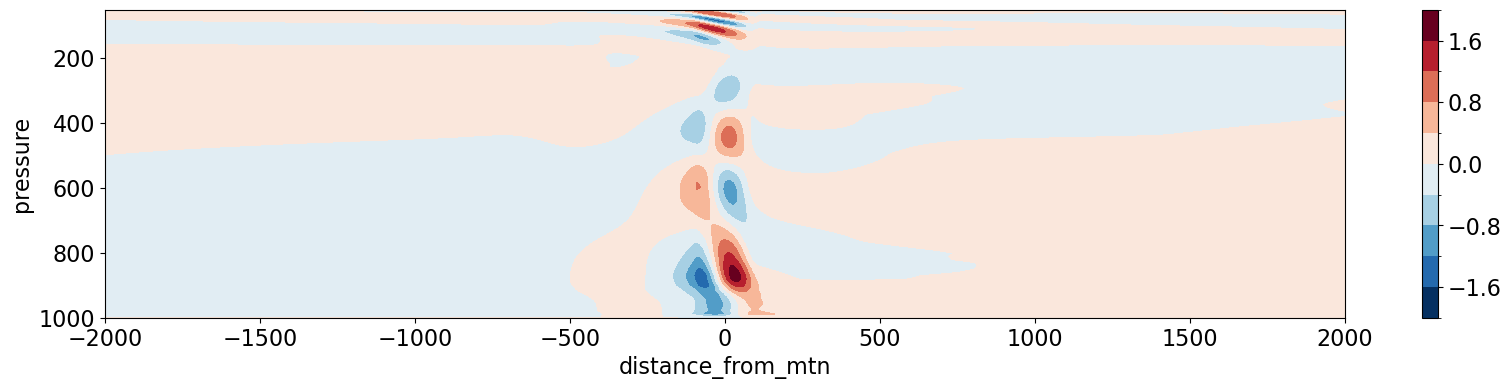

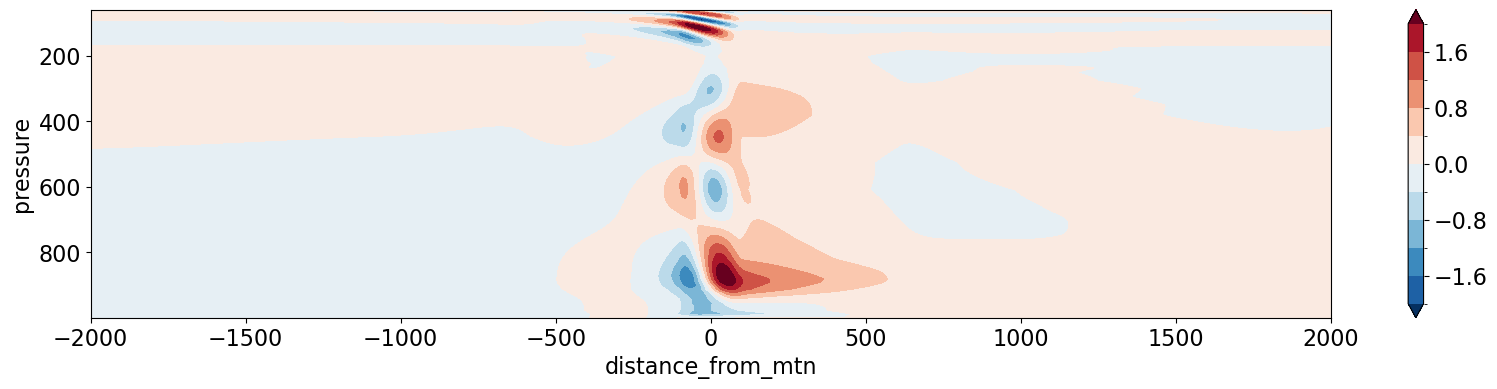

In [35]:
fig,ax = plt.subplots(1,1,figsize=(20,4))
T_long_eps1.swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=np.linspace(-2,2,11))
ax.set_xlim(-2000,2000)
fig,ax = plt.subplots(1,1,figsize=(20,4))
Tprime_.plot.contourf(ax=ax,y='pressure',yincrease=False,levels=np.linspace(-2,2,11))
ax.set_xlim(-2000,2000)



(-2000.0, 2000.0)

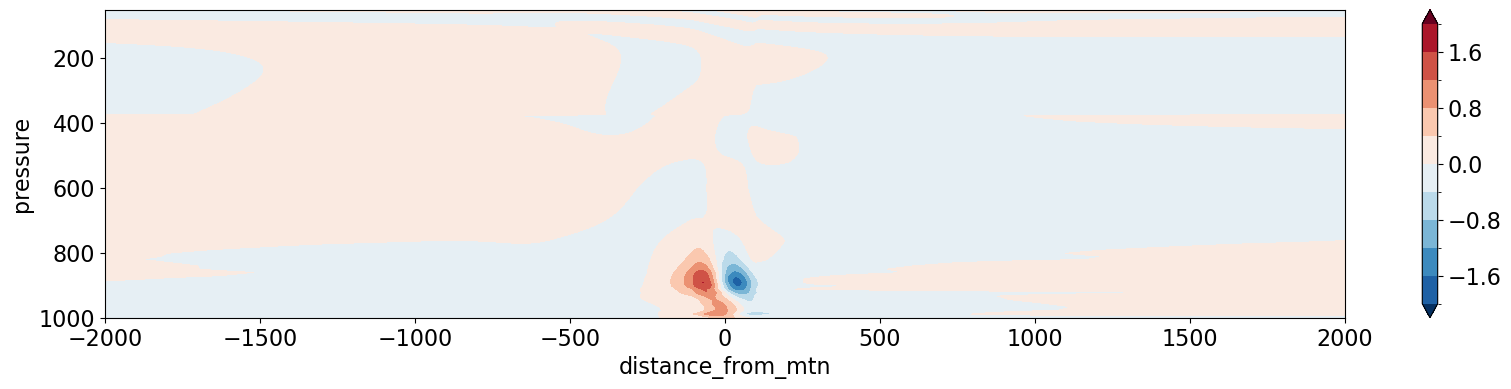

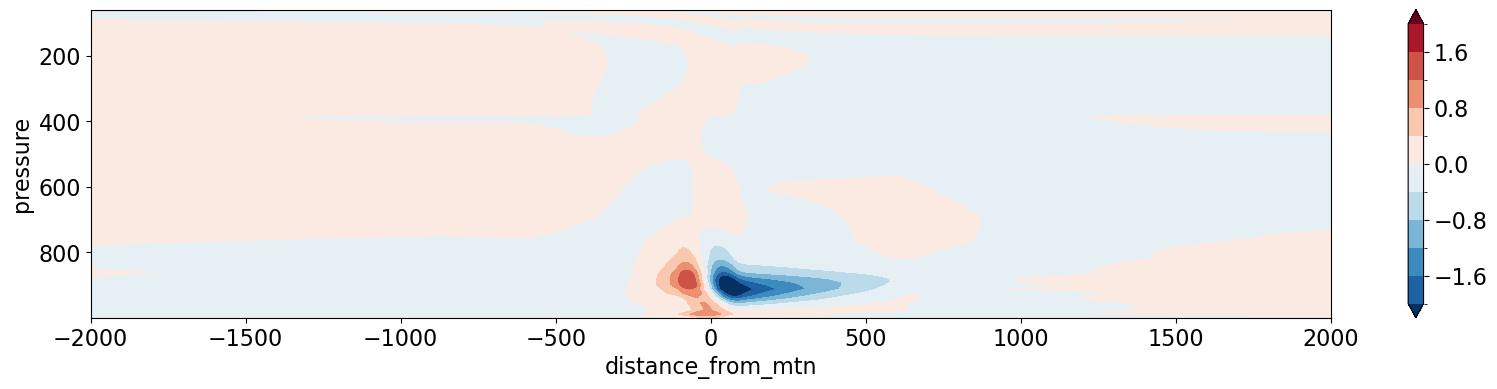

In [36]:
fig,ax = plt.subplots(1,1,figsize=(20,4))
q_long_eps1.swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=np.linspace(-2,2,11),extend='both')
ax.set_xlim(-2000,2000)
fig,ax = plt.subplots(1,1,figsize=(20,4))
qprime_.plot.contourf(ax=ax,y='pressure',yincrease=False,levels=np.linspace(-2,2,11),extend='both')
ax.set_xlim(-2000,2000)



(-2000.0, 2000.0)

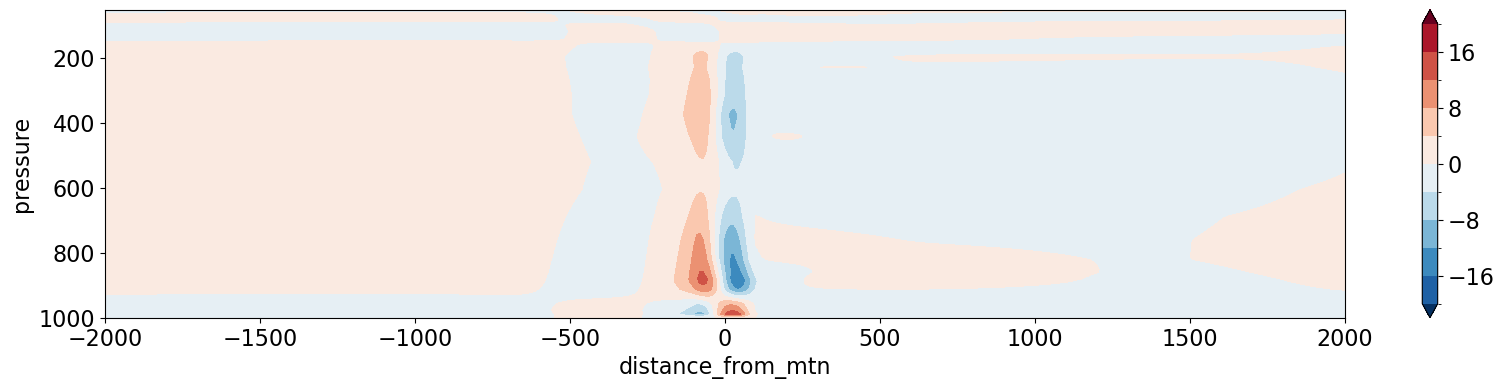

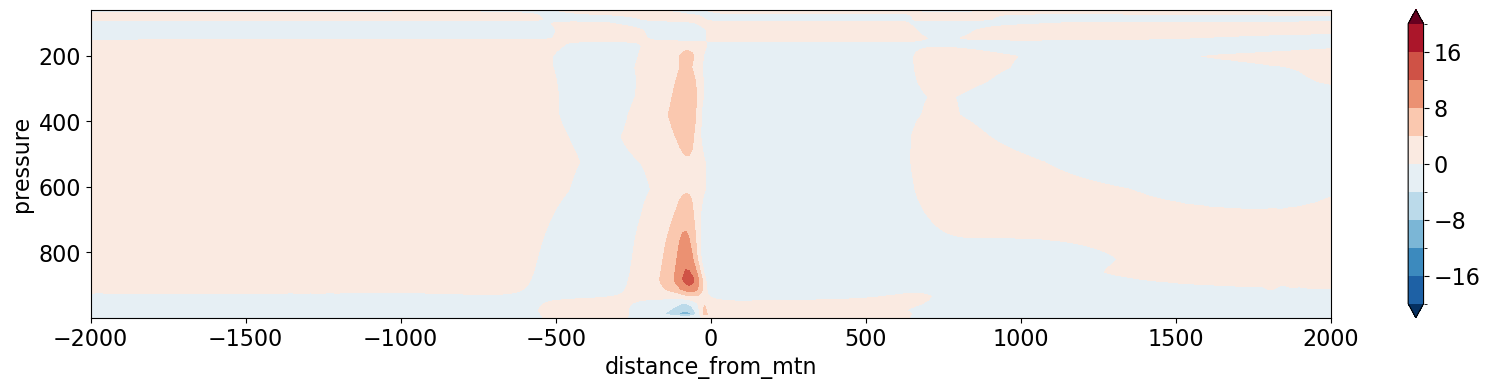

In [37]:
fig,ax = plt.subplots(1,1,figsize=(20,4))
(86400*Qc_long_eps1).swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=np.linspace(-20,20,11),extend='both')
ax.set_xlim(-2000,2000)
fig,ax = plt.subplots(1,1,figsize=(20,4))
(86400*Qc_).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=np.linspace(-20,20,11),extend='both')
ax.set_xlim(-2000,2000)



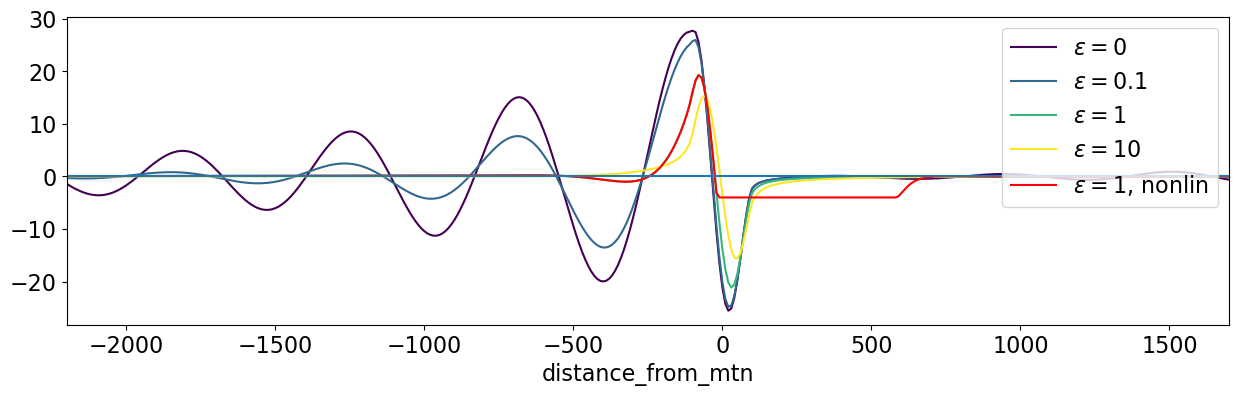

In [38]:
plt.figure(figsize=(15,4))
colors = plt.cm.viridis(np.linspace(0.,1.,4))
for Qc,clr,eps_str in zip((Qc_long_eps0,Qc_long_eps01,Qc_long_eps1,Qc_long_eps10),colors,("0","0.1","1","10")):
    (-Qc.integrate('pressure')*cp/Lv/g*100*86400).plot(label=r"$\epsilon=%s$"%eps_str,color=clr)
(-Qc_.integrate('pressure')*cp/Lv/g*100*86400).plot(label=r"$\epsilon=1$, nonlin",color='r')
plt.xlim(-2200,1700)
plt.axhline(0.)
plt.legend(loc=1)

In [44]:
%time ww_long_eps1,T_long_eps1,q_long_eps1,Qc_long_eps1,_ = sum_sol(start=500,stride=2,coupling='full',eps=1/86400,MM=Mkuang2/2.5)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 31.8 s, sys: 6.38 s, total: 38.1 s
Wall time: 19.1 s


In [45]:
%time ww_long_eps0,_,_,Qc_long_eps0,_ = sum_sol(start=500,stride=2,coupling='full',eps=0.,MM=Mkuang2/2.5)
%time ww_long_eps01,_,_,Qc_long_eps01,_ = sum_sol(start=500,stride=2,coupling='full',eps=1/86400/10,MM=Mkuang2/2.5)
%time ww_long_eps10,_,_,Qc_long_eps10,_ = sum_sol(start=500,stride=2,coupling='full',eps=1/86400*10,MM=Mkuang2/2.5)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 31.8 s, sys: 6.29 s, total: 38.1 s
Wall time: 19.1 s
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 31.6 s, sys: 6.39 s, total: 38 s
Wall time: 19 s
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 31.9 s, sys: 6.41 s, total: 38.3 s
Wall time: 19.2 s


In [49]:
ww_,Tprime_,qprime_,Qc_,Qq_ = calc_w_general_forced_nonlin(W10S300,stride=2,start=500,MM=Mkuang2/2.5)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

/tmp/ipykernel_34352/2548933865.py:40: RuntimeWarning: invalid value encountered in divide
  QcQq = QcQq * ( (rain<rainthresh)*(rainthresh)/rain + (rain>=rainthresh) )


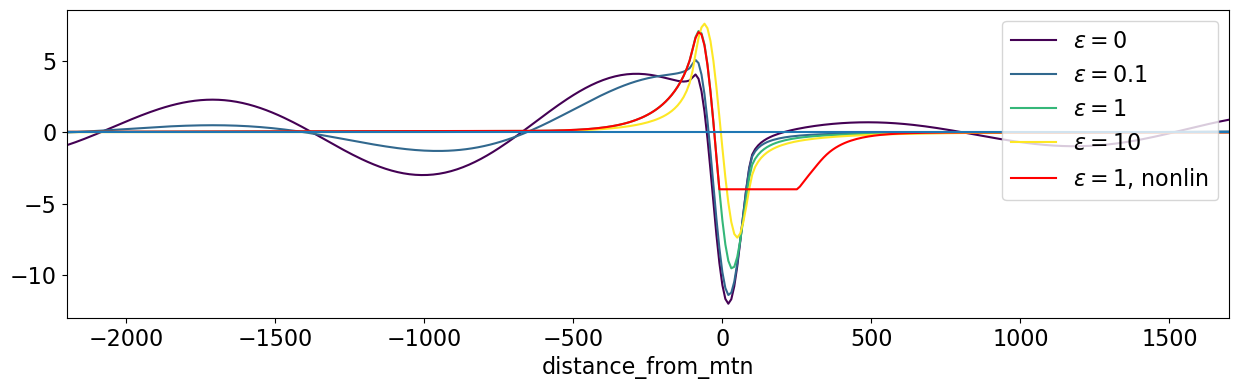

In [50]:
plt.figure(figsize=(15,4))
colors = plt.cm.viridis(np.linspace(0.,1.,4))
for Qc,clr,eps_str in zip((Qc_long_eps0,Qc_long_eps01,Qc_long_eps1,Qc_long_eps10),colors,("0","0.1","1","10")):
    (-Qc.integrate('pressure')*cp/Lv/g*100*86400).plot(label=r"$\epsilon=%s$"%eps_str,color=clr)
(-Qc_.integrate('pressure')*cp/Lv/g*100*86400).plot(label=r"$\epsilon=1$, nonlin",color='r')
plt.xlim(-2200,1700)
plt.axhline(0.)
plt.legend(loc=1)

## vertical motion, coupled and uncoupled

In [26]:
ww_coupled,Tprime_coupled,qprime_coupled,Qc_coupled,Qq_coupled = sum_sol(start=500,stride=2,coupling='full',eps=1/86400,MM=Mkuang2)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

In [27]:
ww_coupled2,Tprime_coupled2,qprime_coupled2,Qc_coupled2,Qq_coupled2 = sum_sol(start=500,stride=2,coupling='full',eps=2/86400,MM=Mkuang2)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

In [28]:
ww_coupled3,Tprime_coupled3,qprime_coupled3,Qc_coupled3,Qq_coupled3 = sum_sol(start=500,stride=2,coupling='full',eps=3/86400,MM=Mkuang2)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

In [29]:
ww_adiab,Tprime_adiab,qprime_adiab,Qc_adiab,Qq_adiab = sum_sol(start=500,stride=2,coupling='full',eps=0.,MM=0.*Mkuang2)
ww_adiabd,Tprime_adiabd,qprime_adiabd,Qc_adiabd,Qq_adiabd = sum_sol(start=500,stride=2,coupling='full',eps=1/86400,MM=0.*Mkuang2)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

In [30]:
ww_adiabd2,Tprime_adiabd2,qprime_adiabd2,Qc_adiabd2,Qq_adiabd2 = sum_sol(start=500,stride=2,coupling='full',eps=2/86400,MM=0.*Mkuang2)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

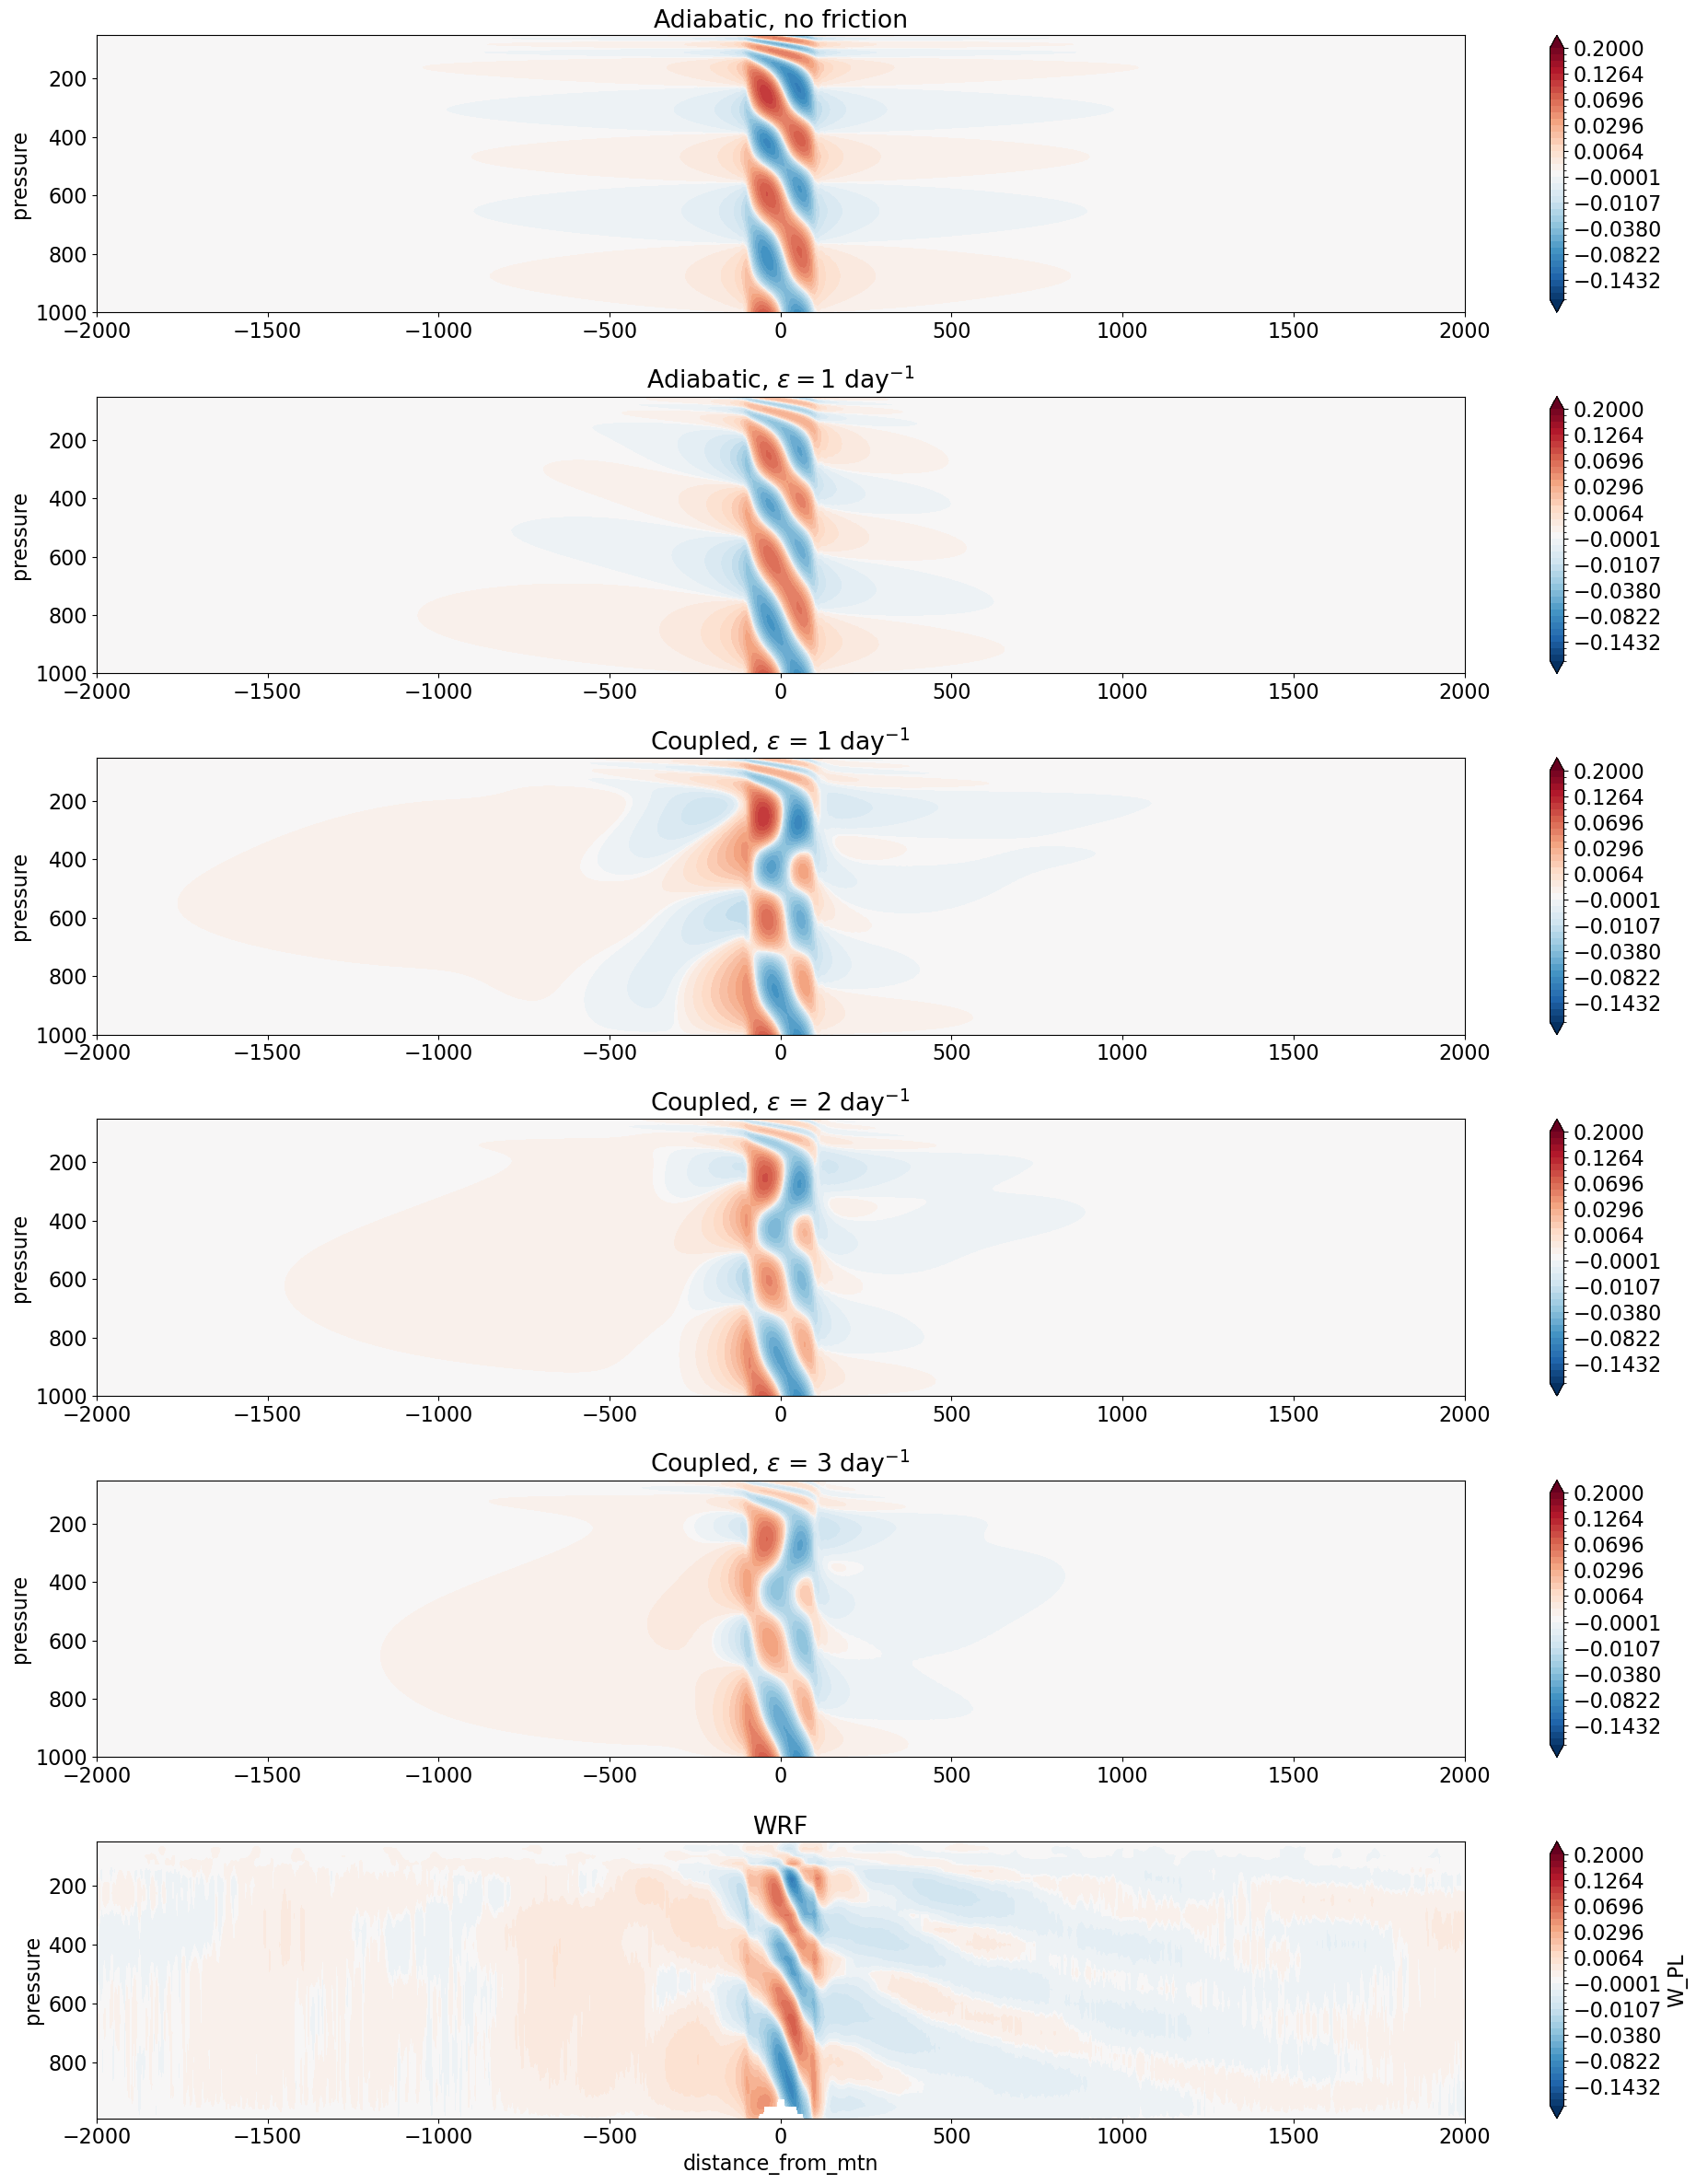

In [51]:
fig,axs = plt.subplots(6,1,figsize=(20,24))
for ax,w in zip(axs,(ww_adiab,ww_adiabd,ww_coupled,ww_coupled2,ww_coupled3)):
    w.swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=levs1,extend='both')
    ax.set_xlim(-2000,2000)
    ax.set_xlabel('')
W10S300.W_PL_MEAN.plot.contourf(ax=axs[-1],y='pressure',yincrease=False,levels=levs1,extend='both')
axs[-1].set_xlim(-2000,2000)

axs[0].set_title('Adiabatic, no friction')
axs[1].set_title(r'Adiabatic, $\epsilon = 1$ day$^{-1}$')
axs[2].set_title(r'Coupled, $\epsilon$ = 1 day$^{-1}$')
axs[3].set_title(r'Coupled, $\epsilon$ = 2 day$^{-1}$')
axs[4].set_title(r'Coupled, $\epsilon$ = 3 day$^{-1}$')
axs[5].set_title(r'WRF')
fig.tight_layout()

In [52]:
ww_coupled2_Mhalf,Tprime_coupled2_Mhalf,qprime_coupled2_Mhalf,Qc_coupled2_Mhalf,Qq_coupled2_Mhalf = sum_sol(start=500,stride=2,coupling='full',eps=2/86400,MM=Mkuang2/2.5)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

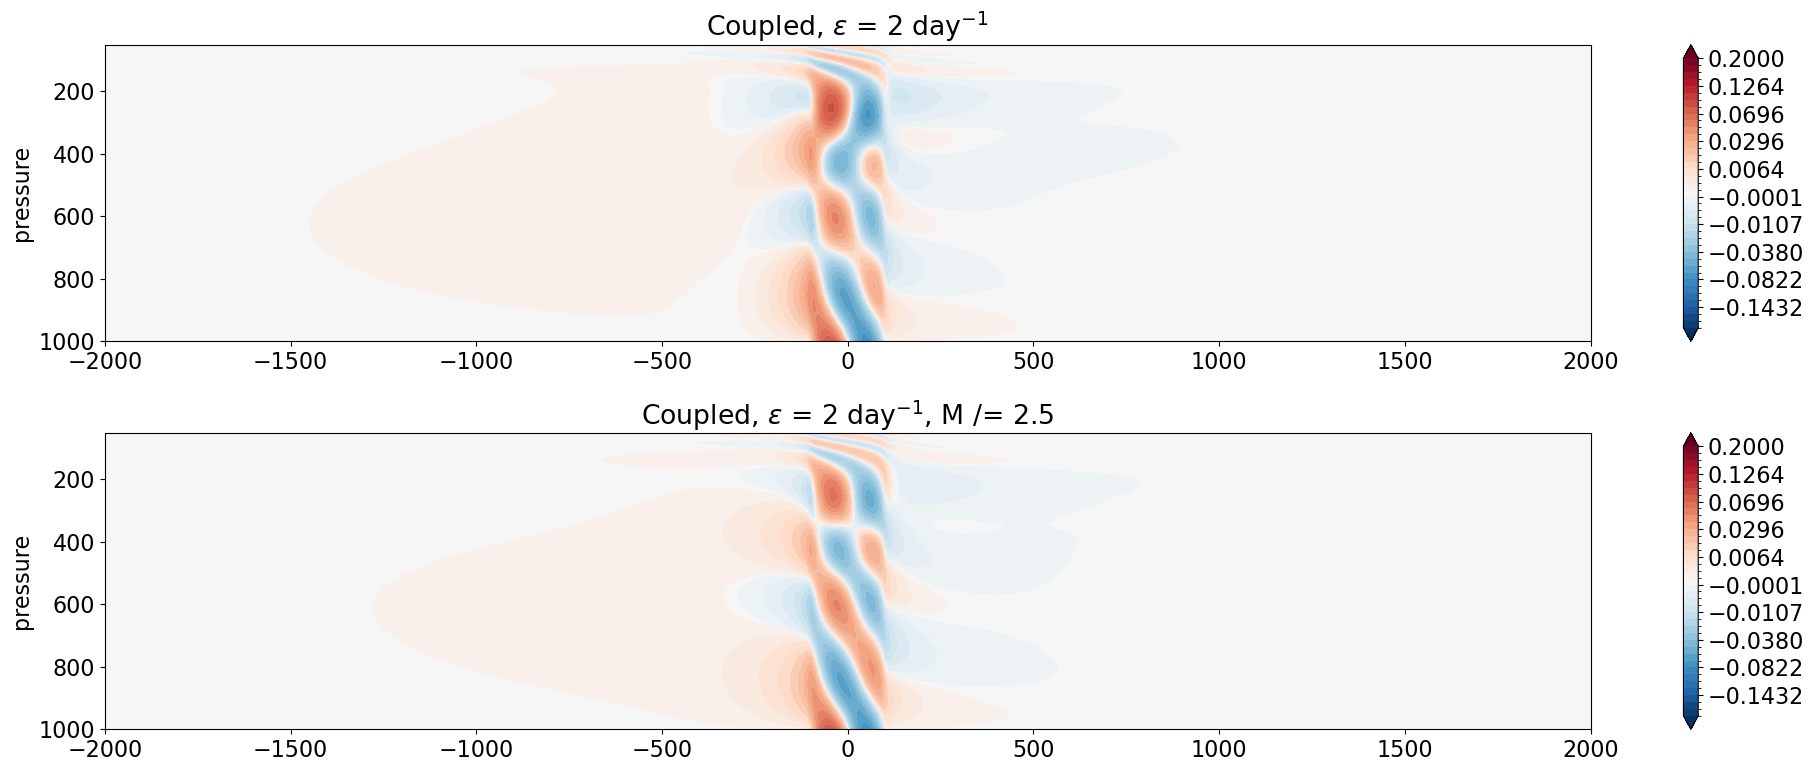

In [54]:
fig,axs = plt.subplots(2,1,figsize=(20,8))
for ax,w in zip(axs,(ww_coupled2,ww_coupled2_Mhalf)):
    w.swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=levs1,extend='both')
    ax.set_xlim(-2000,2000)
    ax.set_xlabel('')
    
axs[0].set_title(r'Coupled, $\epsilon$ = 2 day$^{-1}$')
axs[1].set_title(r'Coupled, $\epsilon$ = 2 day$^{-1}$, M /= 2.5')
fig.tight_layout()

## Temperature/moisture perturbations

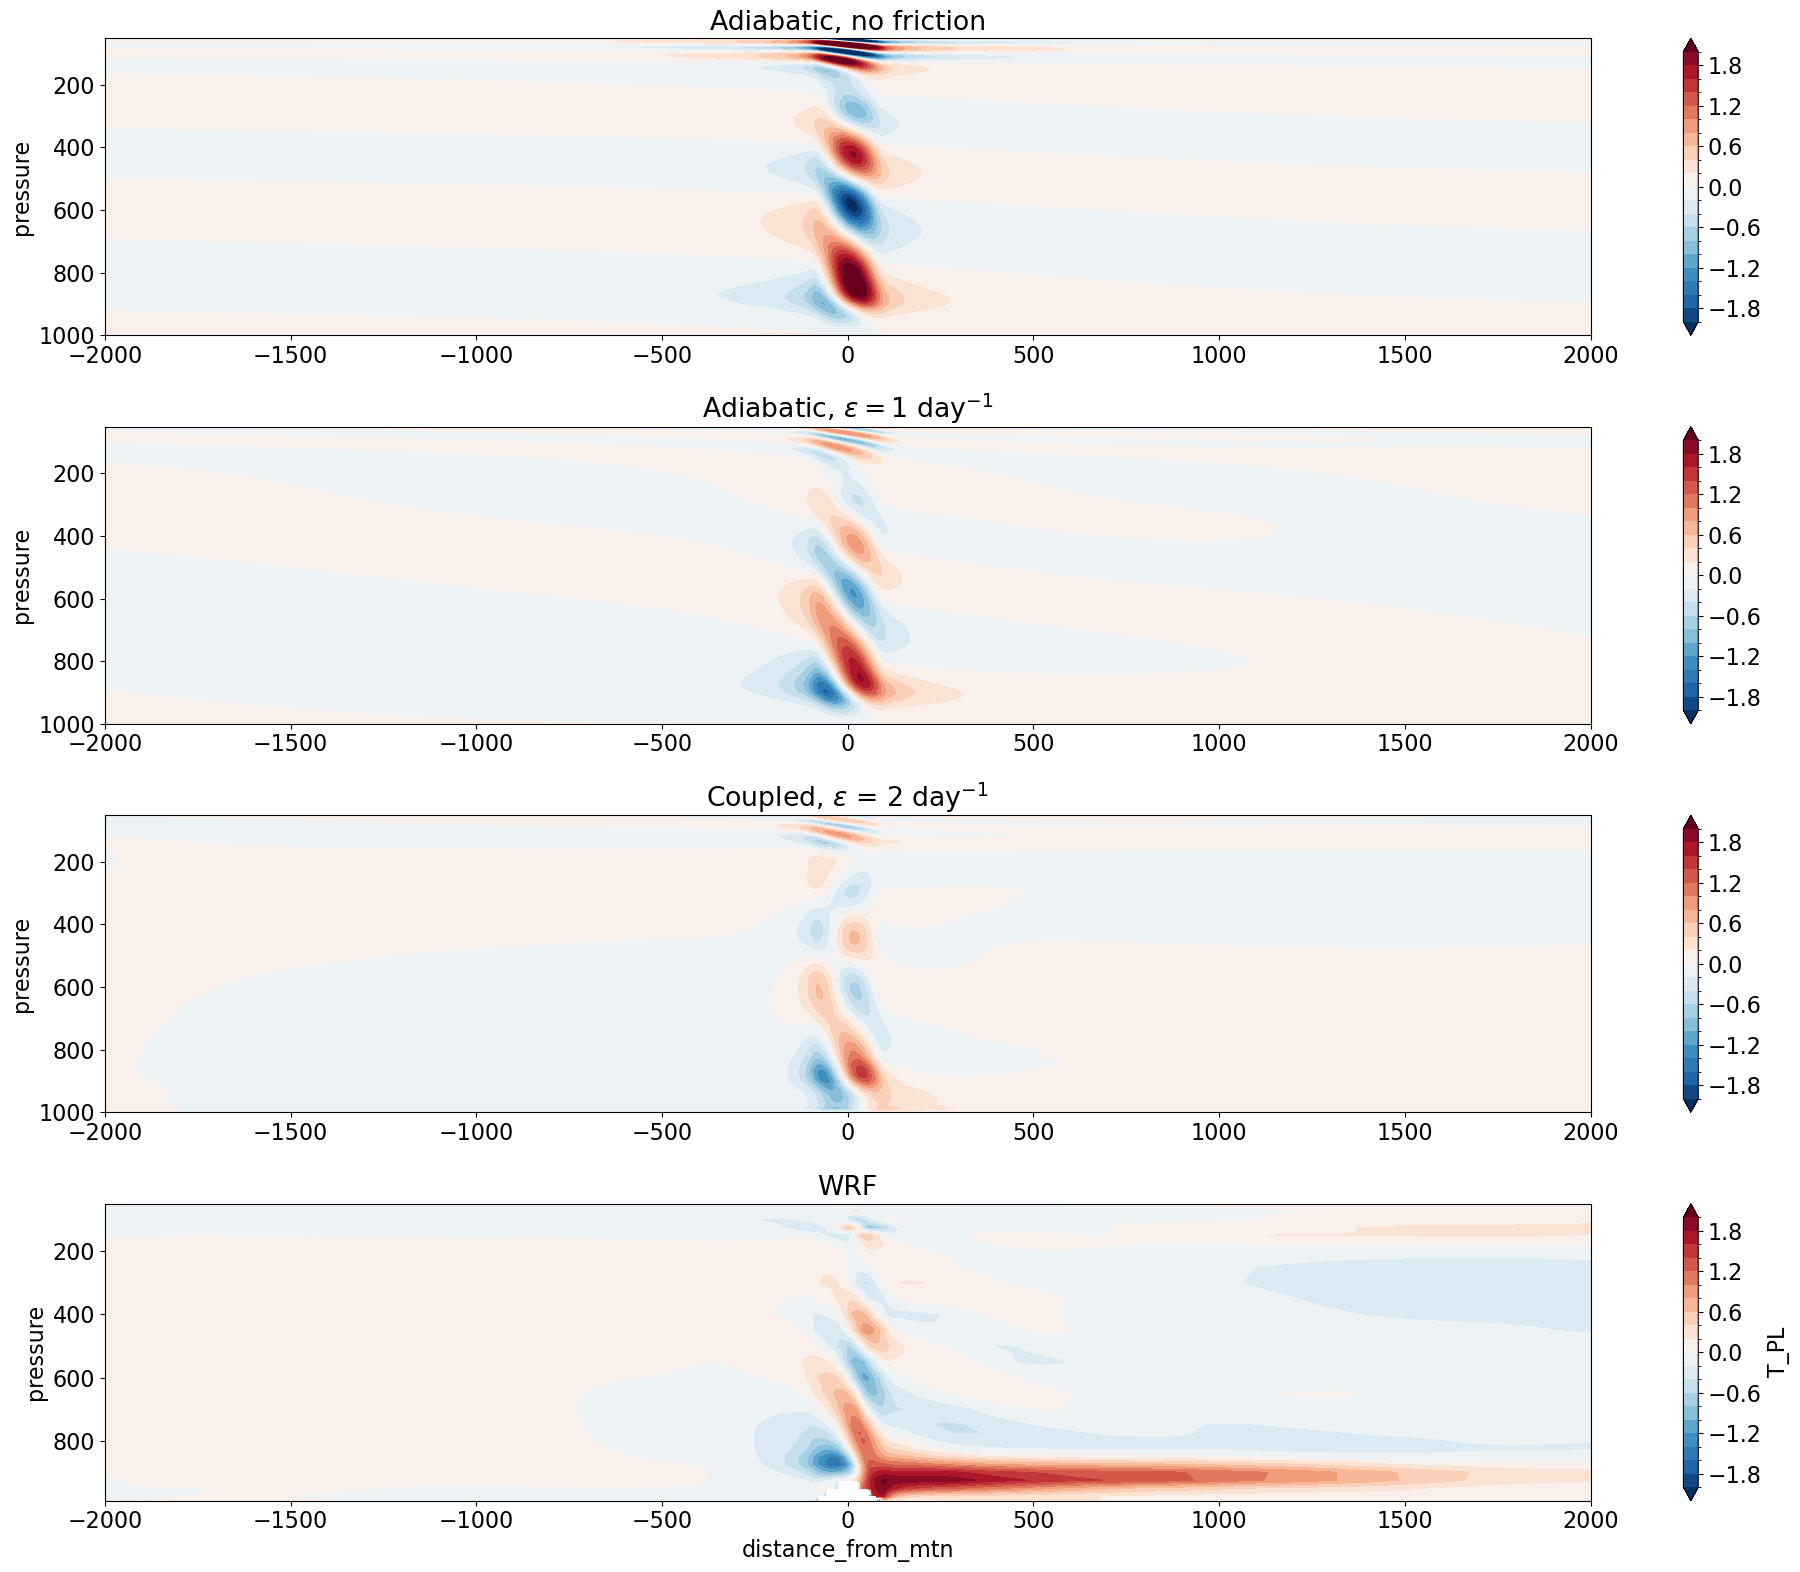

In [37]:
fig,axs = plt.subplots(4,1,figsize=(20,16))
levsT = np.linspace(-2,2,21)
for ax,w in zip(axs,(Tprime_adiab,Tprime_adiabd,Tprime_coupled2)):
    w.swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=levsT,extend='both')
    ax.set_xlim(-2000,2000)
    ax.set_xlabel('')
(W10S300.T_PL_MEAN-W10S300.T_PL_MEAN[:,2200:].mean('distance_from_mtn')).plot.contourf(ax=axs[-1],y='pressure',yincrease=False,levels=levsT,extend='both')
axs[-1].set_xlim(-2000,2000)

axs[0].set_title('Adiabatic, no friction')
axs[1].set_title(r'Adiabatic, $\epsilon = 1$ day$^{-1}$')
axs[2].set_title(r'Coupled, $\epsilon$ = 2 day$^{-1}$')
axs[3].set_title(r'WRF')
fig.tight_layout()

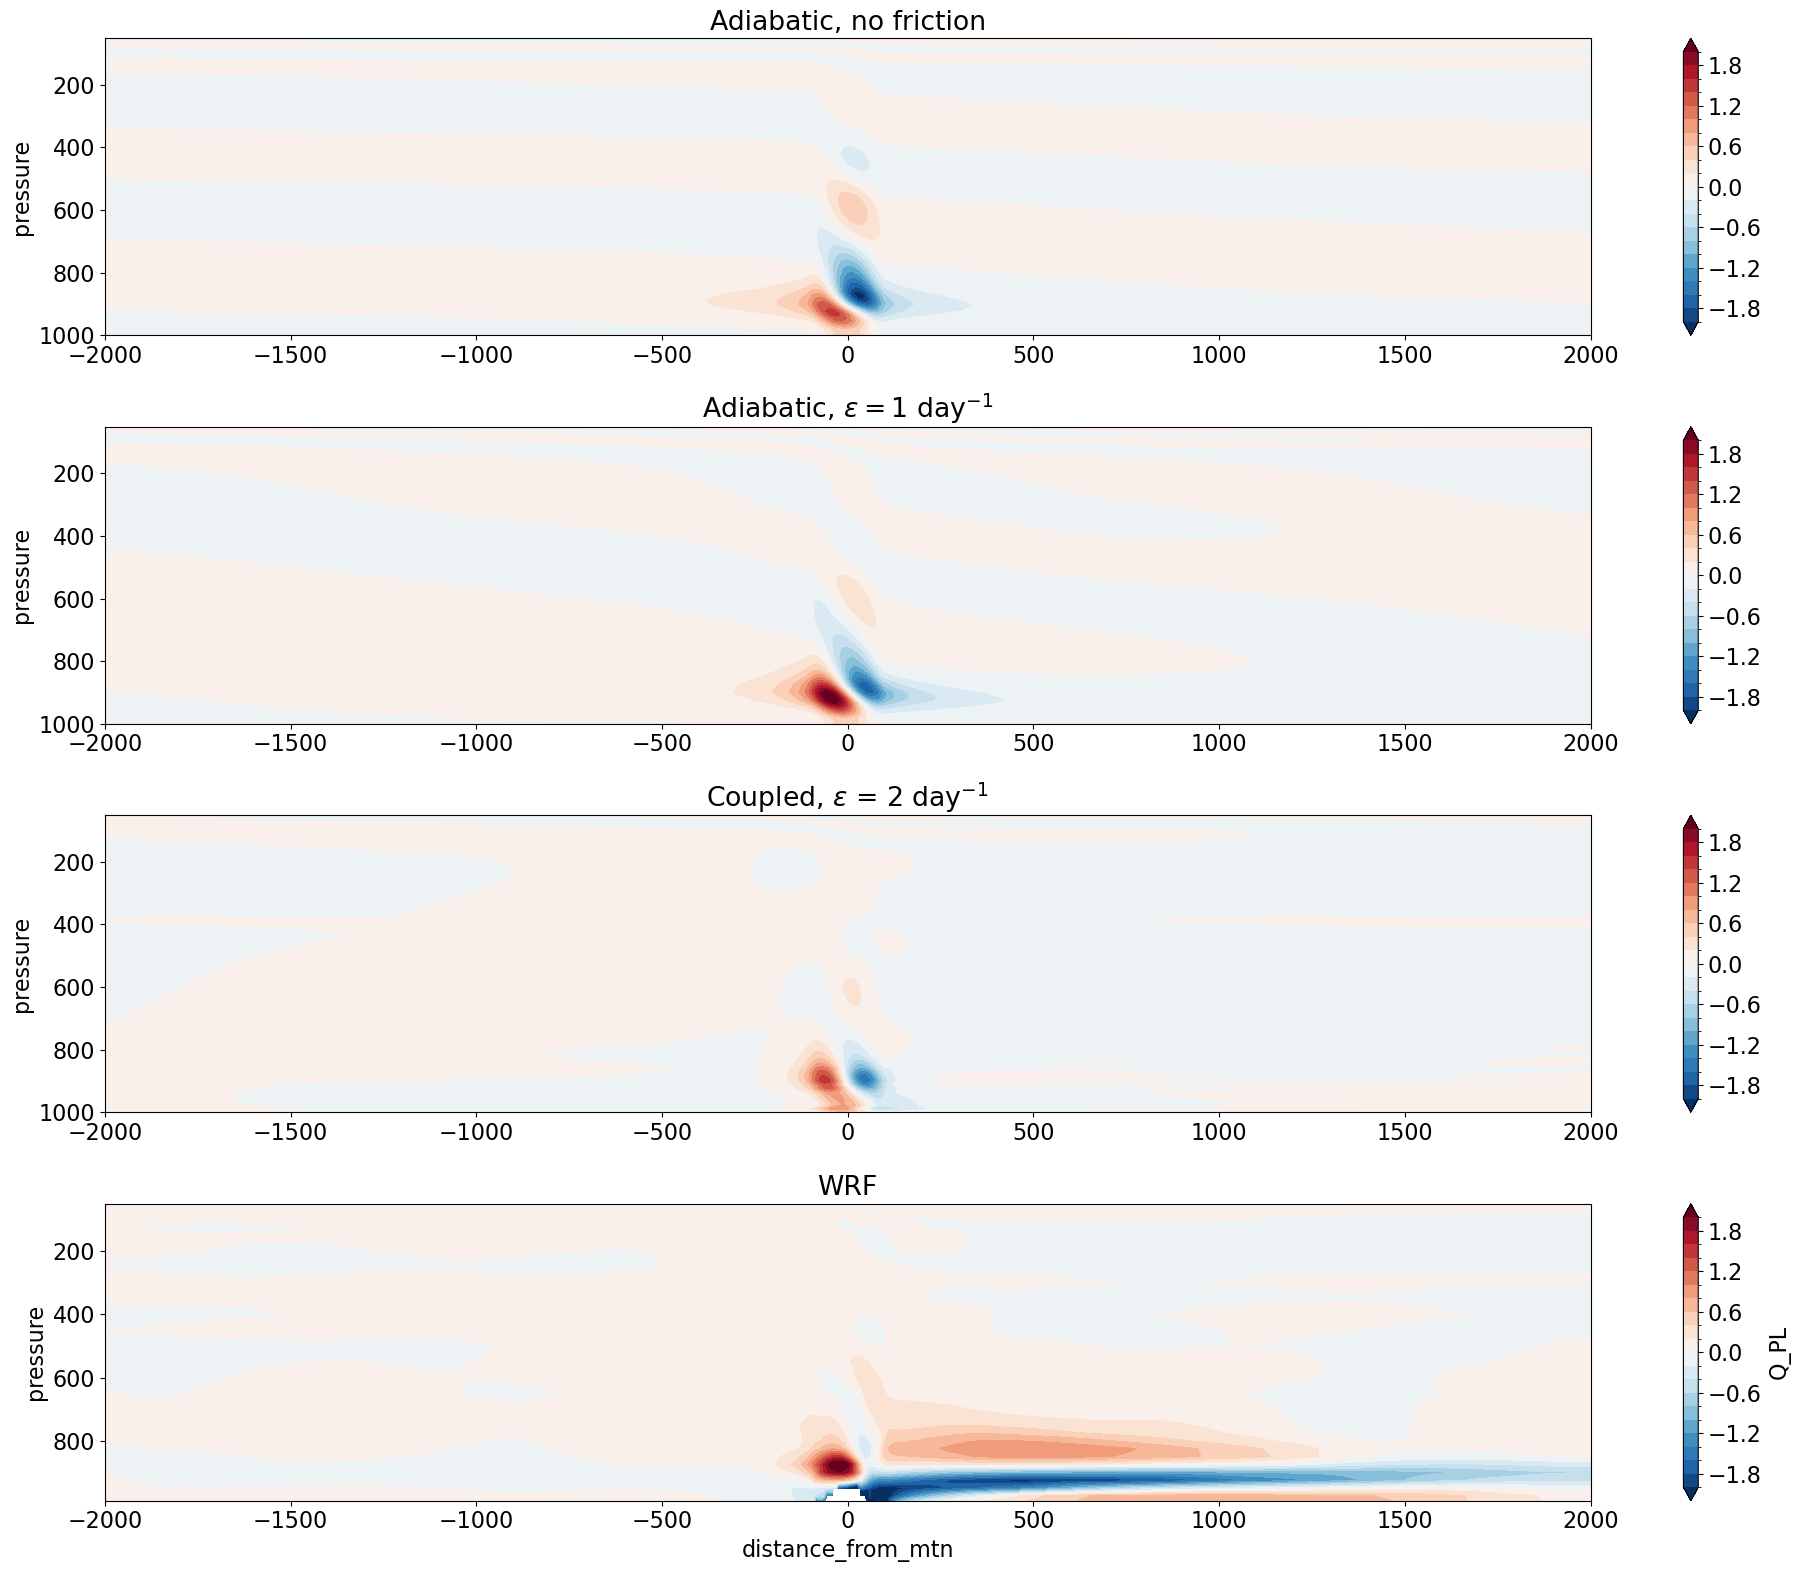

In [39]:
fig,axs = plt.subplots(4,1,figsize=(20,16))
levsq = np.linspace(-2,2,21)
for ax,w in zip(axs,(qprime_adiab,qprime_adiabd,qprime_coupled2)):
    w.swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=levsq,extend='both')
    ax.set_xlim(-2000,2000)
    ax.set_xlabel('')
(1e3*(W10S300.Q_PL_MEAN-W10S300.Q_PL_MEAN[:,2200:].mean('distance_from_mtn'))).plot.contourf(ax=axs[-1],y='pressure',yincrease=False,levels=levsq,extend='both')
axs[-1].set_xlim(-2000,2000)

axs[0].set_title('Adiabatic, no friction')
axs[1].set_title(r'Adiabatic, $\epsilon = 1$ day$^{-1}$')
axs[2].set_title(r'Coupled, $\epsilon$ = 2 day$^{-1}$')
axs[3].set_title(r'WRF')
fig.tight_layout()

## cross-sections

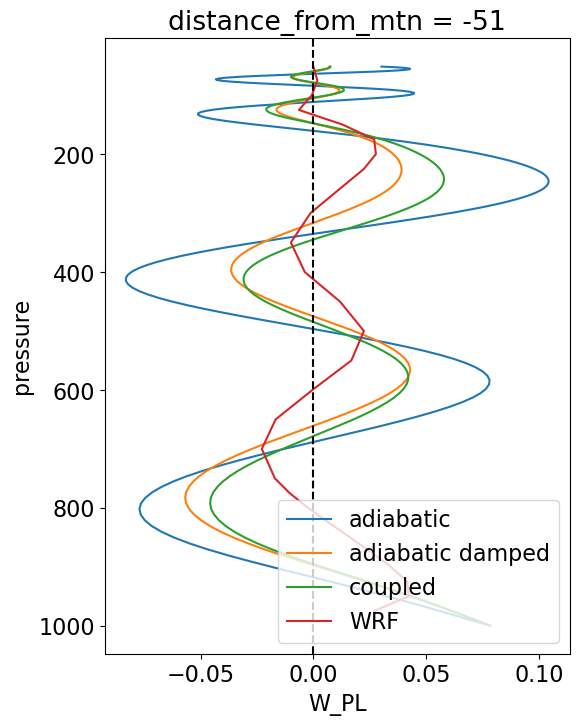

In [69]:
_,ax=plt.subplots(1,1,figsize=(6,8))
ww_adiab.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='adiabatic')
ww_adiabd2.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='adiabatic damped')
ww_coupled2_Mhalf.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='coupled')
W10S300.W_PL_MEAN.sel(distance_from_mtn=-51).plot(ax=ax,y='pressure',yincrease=False,label='WRF')

ax.axvline(0.,color='k',linestyle='--')
ax.legend()

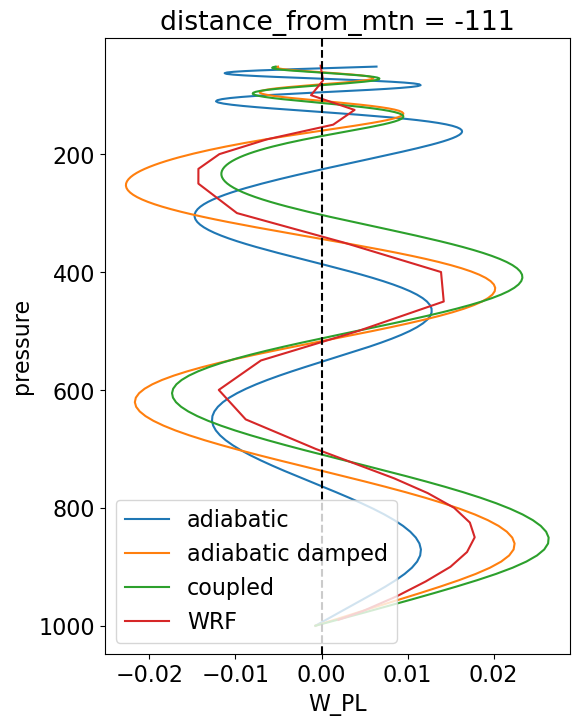

In [70]:
_,ax=plt.subplots(1,1,figsize=(6,8))
ww_adiab.sel(distance_from_mtn=-110).plot(y='pressure',yincrease=False,label='adiabatic')
ww_adiabd2.sel(distance_from_mtn=-110).plot(y='pressure',yincrease=False,label='adiabatic damped')
ww_coupled2_Mhalf.sel(distance_from_mtn=-110).plot(y='pressure',yincrease=False,label='coupled')
W10S300.W_PL_MEAN.sel(distance_from_mtn=-111).plot(ax=ax,y='pressure',yincrease=False,label='WRF')

ax.axvline(0.,color='k',linestyle='--')
ax.legend()

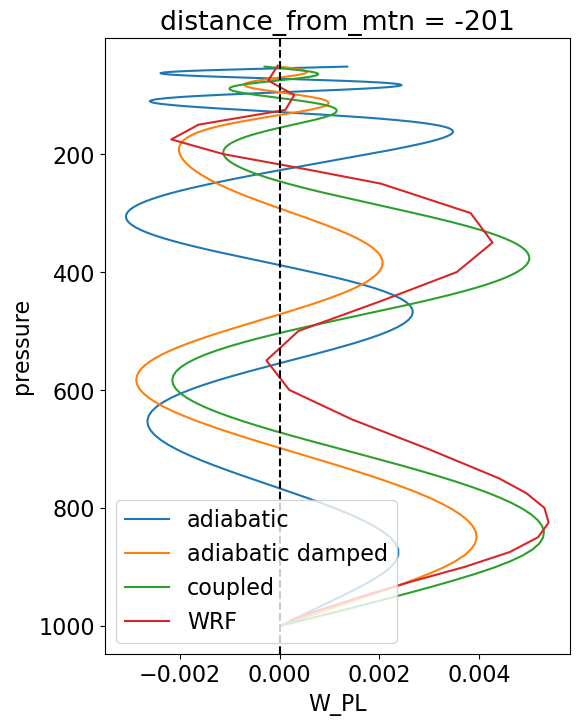

In [76]:
_,ax=plt.subplots(1,1,figsize=(6,8))
ww_adiab.sel(distance_from_mtn=-200).plot(y='pressure',yincrease=False,label='adiabatic')
ww_adiabd2.sel(distance_from_mtn=-200).plot(y='pressure',yincrease=False,label='adiabatic damped')
ww_coupled2_Mhalf.sel(distance_from_mtn=-200).plot(y='pressure',yincrease=False,label='coupled')
W10S300.W_PL_MEAN.sel(distance_from_mtn=-201).plot(ax=ax,y='pressure',yincrease=False,label='WRF')

ax.axvline(0.,color='k',linestyle='--')
ax.legend()

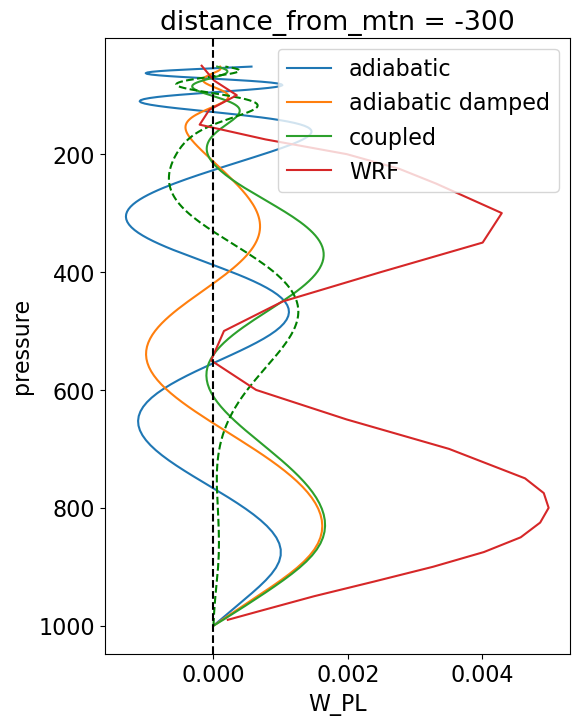

In [73]:
_,ax=plt.subplots(1,1,figsize=(6,8))
ww_adiab.sel(distance_from_mtn=-300).plot(y='pressure',yincrease=False,label='adiabatic')
ww_adiabd2.sel(distance_from_mtn=-300).plot(y='pressure',yincrease=False,label='adiabatic damped')
ww_coupled2_Mhalf.sel(distance_from_mtn=-300).plot(y='pressure',yincrease=False,label='coupled')
ww_coupled2.sel(distance_from_mtn=-300).plot(y='pressure',yincrease=False,color='g',linestyle='--')
W10S300.W_PL_MEAN.sel(distance_from_mtn=-300).plot(ax=ax,y='pressure',yincrease=False,label='WRF')

ax.axvline(0.,color='k',linestyle='--')
ax.legend()

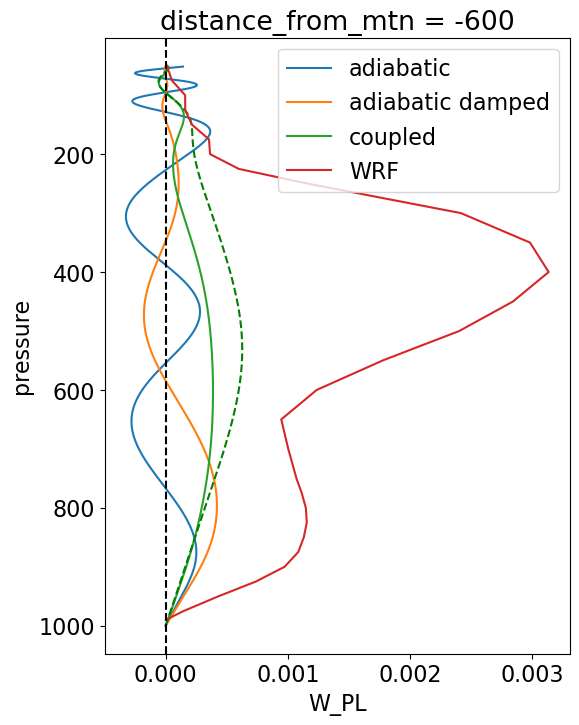

In [74]:
_,ax=plt.subplots(1,1,figsize=(6,8))
ww_adiab.sel(distance_from_mtn=-600).plot(y='pressure',yincrease=False,label='adiabatic')
ww_adiabd2.sel(distance_from_mtn=-600).plot(y='pressure',yincrease=False,label='adiabatic damped')
ww_coupled2_Mhalf.sel(distance_from_mtn=-600).plot(y='pressure',yincrease=False,label='coupled')
ww_coupled2.sel(distance_from_mtn=-600).plot(y='pressure',yincrease=False,color='g',linestyle='--')
W10S300.W_PL_MEAN.sel(distance_from_mtn=-600).plot(ax=ax,y='pressure',yincrease=False,label='WRF')

ax.axvline(0.,color='k',linestyle='--')
ax.legend()

In [116]:
def w_modified_forcing(qxz,stride=6,start=34,eps=1/86400):#niter_per_mode=4
    xx ,hx = topographic_profile('cos',A=500)
    xx = xx[2000-start:2000+start+1:stride]
    hx = hx[2000-start:2000+start+1:stride]

    return linear_w_generalized_forced(xx,hx,zz_full,10.*zz_full**0,np.sqrt(W10S300.N2TEST_full),eps,qxz*g/T0)
   
surf = (Qc_coupled2_Mhalf.distance_from_mtn>-100)*(Qc_coupled2_Mhalf.distance_from_mtn<100)*(Qc_coupled2_Mhalf.pressure>900)*1e-4
ww_test = w_modified_forcing(Qc_coupled2_Mhalf+surf,stride=2,start=500,eps=2/86400)

0 500 

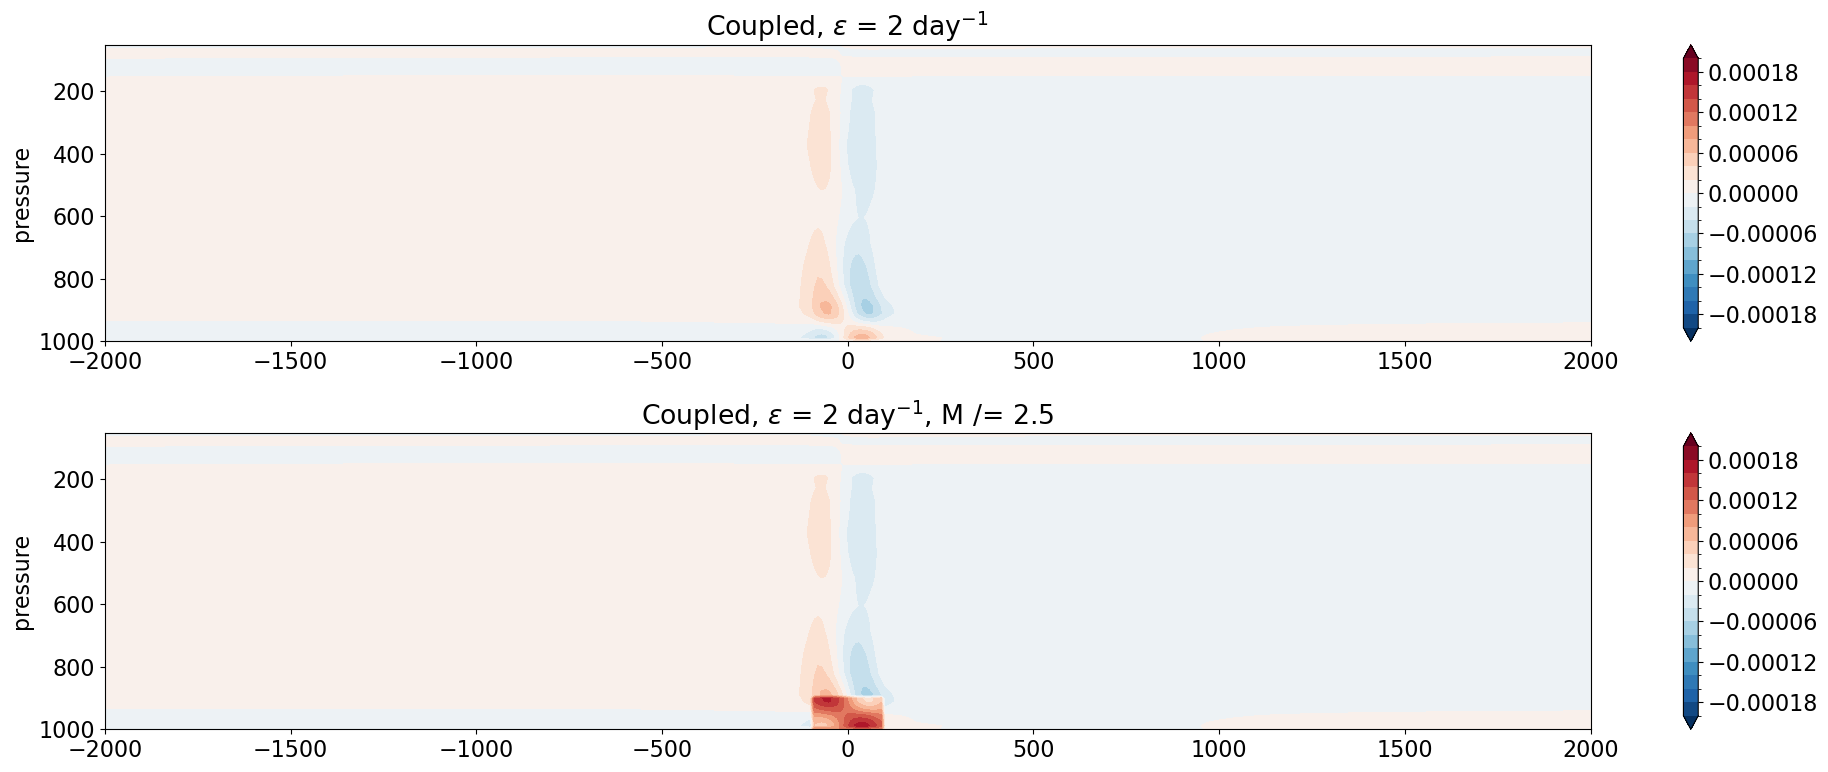

In [117]:
fig,axs = plt.subplots(2,1,figsize=(20,8))
for ax,w in zip(axs,(Qc_coupled2_Mhalf,Qc_coupled2_Mhalf+surf)):
    w.swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=np.linspace(-20e-5,20e-5,21),extend='both')
    ax.set_xlim(-2000,2000)
    ax.set_xlabel('')
    
axs[0].set_title(r'Coupled, $\epsilon$ = 2 day$^{-1}$')
axs[1].set_title(r'Coupled, $\epsilon$ = 2 day$^{-1}$, M /= 2.5')
fig.tight_layout()

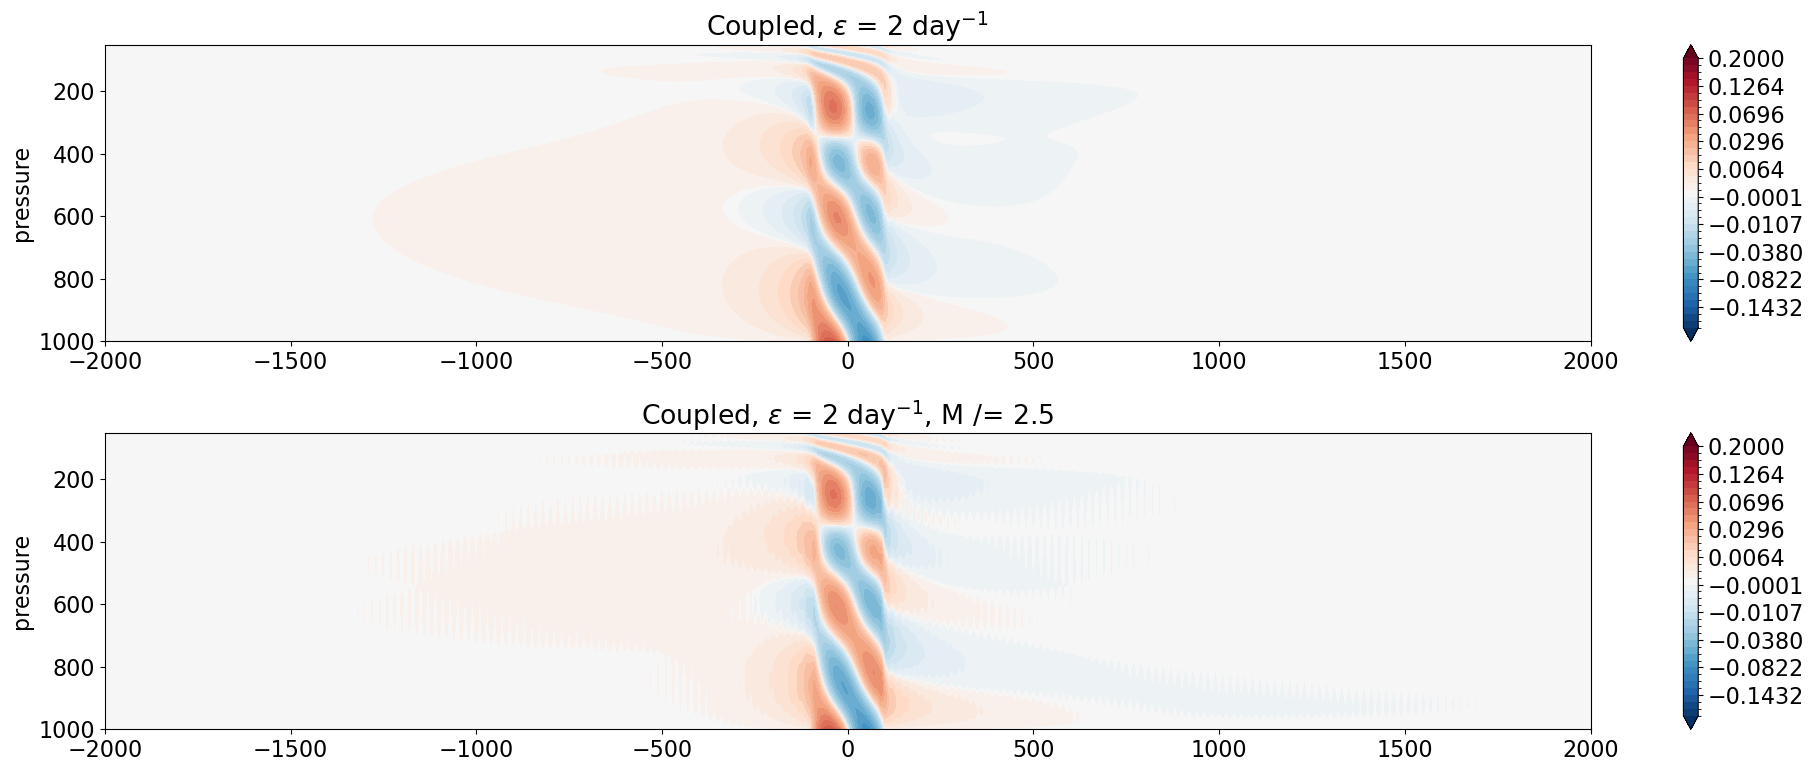

In [118]:
fig,axs = plt.subplots(2,1,figsize=(20,8))
for ax,w in zip(axs,(ww_coupled2_Mhalf,ww_test)):
    w.swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=levs1,extend='both')
    ax.set_xlim(-2000,2000)
    ax.set_xlabel('')
    
axs[0].set_title(r'Coupled, $\epsilon$ = 2 day$^{-1}$')
axs[1].set_title(r'Coupled, $\epsilon$ = 2 day$^{-1}$, M /= 2.5')
fig.tight_layout()

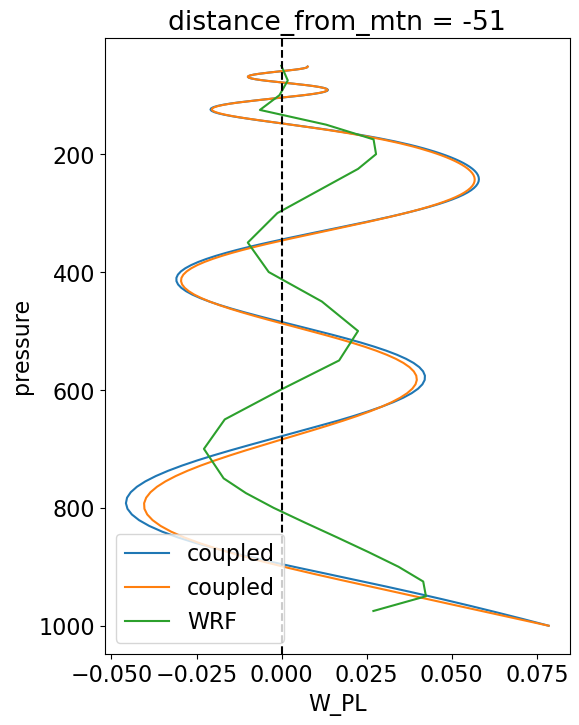

In [119]:
_,ax=plt.subplots(1,1,figsize=(6,8))
ww_coupled2_Mhalf.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='coupled')
ww_test.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='coupled')
W10S300.W_PL_MEAN.sel(distance_from_mtn=-51).plot(ax=ax,y='pressure',yincrease=False,label='WRF')

ax.axvline(0.,color='k',linestyle='--')
ax.legend()

## precip from this and previous theory

In [16]:
from orographicConvectionTheory.orographicConvectionTheory import linear_precip_theory

In [17]:
xx ,hx = topographic_profile('cos',A=500)
P = linear_precip_theory(xx, hx, 10., tauT=7.5*1.1, tauq=27.5*1.1, P0=4.0, switch=1)

In [18]:
ww_,_,_,Qc_coupled2_nonlin,_ = calc_w_general_forced_nonlin(W10S300,stride=2,start=500,eps=2/86400,MM=Mkuang2/2.)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

/tmp/ipykernel_32749/3758316601.py:40: RuntimeWarning: invalid value encountered in divide
  QcQq = QcQq * ( (rain<rainthresh)*(rainthresh)/rain + (rain>=rainthresh) )


In [19]:
ww_coupled2_Mhalff,Tprime_coupled2_Mhalff,qprime_coupled2_Mhalff,Qc_coupled2_Mhalff,Qq_coupled2_Mhalff = sum_sol(start=500,stride=2,coupling='full',eps=2/86400,MM=Mkuang2/2)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

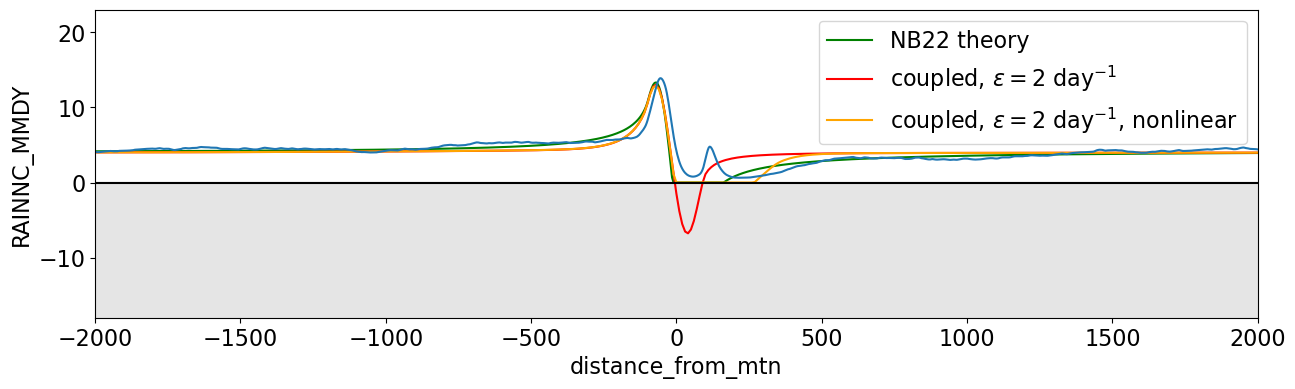

In [20]:
plt.figure(figsize=(15,4))
plt.plot(xx/1e3,P,color='g',label='NB22 theory')
(4.-Qc_coupled2_Mhalff.integrate('pressure')*cp/Lv/g*100*86400).plot(label=r"coupled, $\epsilon=2$ day$^{-1}$",color='r')
(4.-Qc_coupled2_nonlin.integrate('pressure')*cp/Lv/g*100*86400).plot(label=r"coupled, $\epsilon=2$ day$^{-1}$, nonlinear",color='orange')
W10S300.RAINNC[200:].mean(['Time','south_north']).plot()
plt.axhline(0.,color='k')
plt.fill_between(xx,0.*xx,0.*xx-25,color='gray',alpha=0.2)
plt.xlim(-2000,2000)
plt.ylim(-18,23)
plt.legend()

## changing the basic state - but not the coupling matrix

In [21]:
ww_coupled2_Mhalff_296,Tprime_coupled2_Mhalff_296,qprime_coupled2_Mhalff_296,Qc_coupled2_Mhalff_296,Qq_coupled2_Mhalff_296 = sum_sol(start=500,stride=2,coupling='full',eps=2/86400,MM=Mkuang2/2,Sim=W10S296)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

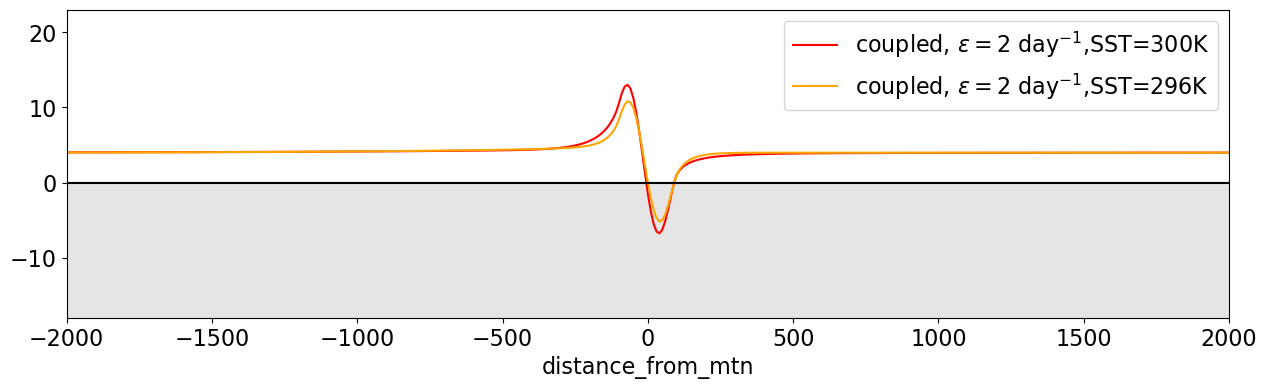

In [23]:
plt.figure(figsize=(15,4))
(4.-Qc_coupled2_Mhalff.integrate('pressure')*cp/Lv/g*100*86400).plot(label=r"coupled, $\epsilon=2$ day$^{-1}$,SST=300K",color='r')
(4.-Qc_coupled2_Mhalff_296.integrate('pressure')*cp/Lv/g*100*86400).plot(label=r"coupled, $\epsilon=2$ day$^{-1}$,SST=296K",color='orange')
#W10S300.RAINNC[200:].mean(['Time','south_north']).plot()
plt.axhline(0.,color='k')
plt.fill_between(xx,0.*xx,0.*xx-25,color='gray',alpha=0.2)
plt.xlim(-2000,2000)
plt.ylim(-18,23)
plt.legend()

In [31]:
86400/3

28800.0